# Définition du projet

Ce projet vise à prédire les zones géographiques (ville, états ou codes postaux) où la demande pour deux produits spécifiques (ThinkPad Laptop et AAA Bateries 4-pack) sera la plus forte. Le but est d'optimiser les décisions logistiques et d'approvisionnement en identifiant les zones géographiques à forte demande.


Les zones géographiques doivent être formatées sous forme "Dallas (TX)', où Dallas représente la ville et TX l'état (ici TX=Texas).



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [2]:
!pip install --upgrade prophet cmdstanpy --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
# from geopy.geocoders import Nominatim
import pandas as pd
import time
# import folium
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
plt.style.use('ggplot')

# Collecte des données

Les données sont telechargé depuis le repos:

https://github.com/ralesabelou-glitch/data-test => all_data.csv

In [5]:
df = pd.read_csv('/content/drive/MyDrive/fluentech/all_data.csv')

Pour notre étude on va se focaliser sur les deux produits:

*   ThinkPad Laptop
*   AAA Batteries (4-pack)



In [6]:
df = df[df['Product'].isin(['ThinkPad Laptop', 'AAA Batteries (4-pack)'])]

# Exploration et visualisation des données

In [7]:
df.head()

Order ID                 Product Quantity Ordered Price Each  \
20   176575  AAA Batteries (4-pack)                1       2.99   
28   176583  AAA Batteries (4-pack)                2       2.99   
32   176586  AAA Batteries (4-pack)                2       2.99   
45   176598  AAA Batteries (4-pack)                2       2.99   
54   176607  AAA Batteries (4-pack)                2       2.99   

        Order Date                        Purchase Address  
20  04/27/19 00:30    433 Hill St, New York City, NY 10001  
28  04/20/19 12:00      146 Jackson St, Portland, OR 97035  
32  04/10/19 17:00  365 Center St, San Francisco, CA 94016  
45  04/21/19 20:33    294 Park St, San Francisco, CA 94016  
54  04/18/19 12:11           689 10th St, Boston, MA 02215

In [8]:
df.shape

(24769, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24769 entries, 20 to 186845
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Order ID          24769 non-null  object
 1   Product           24769 non-null  object
 2   Quantity Ordered  24769 non-null  object
 3   Price Each        24769 non-null  object
 4   Order Date        24769 non-null  object
 5   Purchase Address  24769 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [10]:
df.nunique()

Order ID            24692
Product                 2
Quantity Ordered        9
Price Each              2
Order Date          23935
Purchase Address    23843
dtype: int64

In [11]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [12]:
df['Price Each'] = (
    df['Price Each']
    .astype(float)
)
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce').fillna(0).astype(int)

In [13]:
df.describe()

Quantity Ordered    Price Each
count      24769.000000  24769.000000
mean           1.418991    169.149958
std            0.815401    371.561462
min            1.000000      2.990000
25%            1.000000      2.990000
50%            1.000000      2.990000
75%            2.000000      2.990000
max            9.000000    999.990000

In [14]:
df["Product"].value_counts()

Product
AAA Batteries (4-pack)    20641
ThinkPad Laptop            4128
Name: count, dtype: int64

In [15]:
# Extraire les dates
df['Year'] = pd.to_datetime(df['Order Date'], format="%m/%d/%y %H:%M", errors='coerce').dt.year
df['Month'] = pd.to_datetime(df['Order Date'], format="%m/%d/%y %H:%M", errors='coerce').dt.month
df['Day'] = pd.to_datetime(df['Order Date'], format="%m/%d/%y %H:%M", errors='coerce').dt.dayofyear
df['Date'] = pd.to_datetime(df['Order Date'], format="%m/%d/%y %H:%M", errors='coerce').dt.date
df['Week'] = pd.to_datetime(df['Order Date'], format="%m/%d/%y %H:%M", errors='coerce').dt.isocalendar().week


In [16]:
# Extraire ville et état
city_state = df['Purchase Address'].str.extract(r',\s*([^,]+),\s*([A-Z]{2})\s*\d{5}$')
city_state.columns = ['City', 'State']

# Combiner en un format "Ville (État)"
df['City_State'] = city_state['City'] + ' (' + city_state['State'] + ')'

In [17]:
df['prices'] = df['Quantity Ordered'] * df['Price Each']

In [18]:
df.drop('Order Date', inplace=True, axis=1)
df.drop('Price Each', inplace=True, axis=1)
df.drop('Purchase Address', inplace=True, axis=1)
df.drop('Order ID', inplace=True, axis=1)
df.rename(columns={'Quantity Ordered': 'Quantity'}, inplace=True)

In [19]:
df.head()

Product  Quantity  Year  Month  Day        Date  Week  \
20  AAA Batteries (4-pack)         1  2019      4  117  2019-04-27    17   
28  AAA Batteries (4-pack)         2  2019      4  110  2019-04-20    16   
32  AAA Batteries (4-pack)         2  2019      4  100  2019-04-10    15   
45  AAA Batteries (4-pack)         2  2019      4  111  2019-04-21    16   
54  AAA Batteries (4-pack)         2  2019      4  108  2019-04-18    16   

            City_State  prices  
20  New York City (NY)    2.99  
28       Portland (OR)    5.98  
32  San Francisco (CA)    5.98  
45  San Francisco (CA)    5.98  
54         Boston (MA)    5.98

In [20]:
month_sales = df.pivot_table(values='Quantity', index='Month', columns='Product', aggfunc='sum')
month_sales

Product  AAA Batteries (4-pack)  ThinkPad Laptop
Month                                           
1                          1600              219
2                          1972              275
3                          2479              345
4                          2939              390
5                          2927              371
6                          2162              314
7                          2365              319
8                          2021              274
9                          1923              249
10                         3363              461
11                         3025              374
12                         4241              539

In [21]:
year_sales = df.pivot_table(values='Quantity', index='Year', columns='Product', aggfunc='sum')
year_sales

Product  AAA Batteries (4-pack)  ThinkPad Laptop
Year                                            
2019                      31012             4128
2020                          5                2

In [22]:
machines = ["ThinkPad Laptop"]
batteries = ["AAA Batteries (4-pack)"]

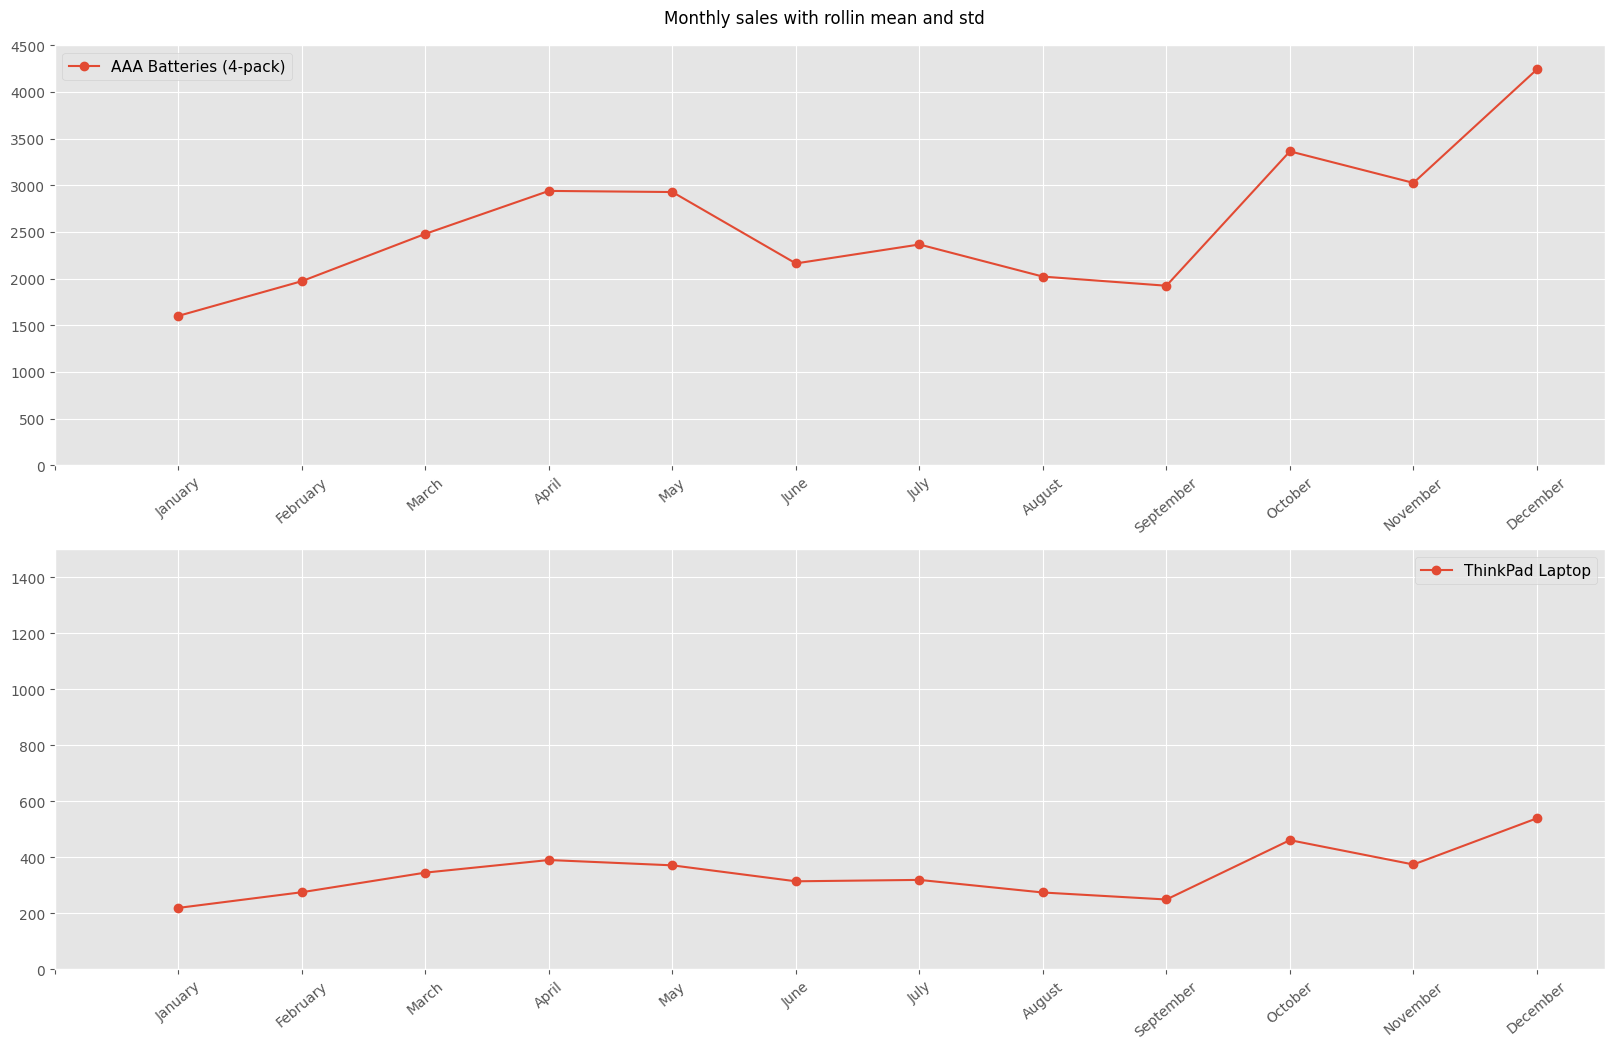

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))
axes = axes.flatten()
for ax, product in zip(axes, [batteries, machines]):
    ax.plot(month_sales[product], marker='o');

    ax.legend(month_sales[product], ncol=3, fontsize=11)
    if product == ['AAA Batteries (4-pack)']:
      ax.set_ylim(0, 4500)
    else:
      ax.set_ylim(0, 1500)
    ax.set_xticks(np.arange(13))
    ax.set_xticklabels(calendar.month_name, rotation=40)
fig.suptitle('Monthly sales with rollin mean and std', y=.91, x=.51);

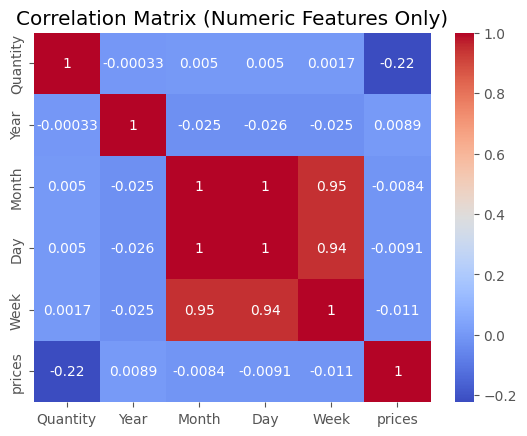

In [24]:
num_df = df.select_dtypes(include=['number'])
correlation_matrix = num_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features Only)')
plt.show()

In [25]:
def moving_average(product_name, n):
    series = df[df['Product'] == product_name].groupby('Week').count()['Quantity']

    rolling_mean = series.rolling(window=n).mean()

    rolling_std =  series.rolling(window=n).std()
    upper_bound = rolling_mean+1.96*rolling_std
    lower_bound = rolling_mean-1.96*rolling_std
    return [series[n:], rolling_mean, upper_bound, lower_bound]

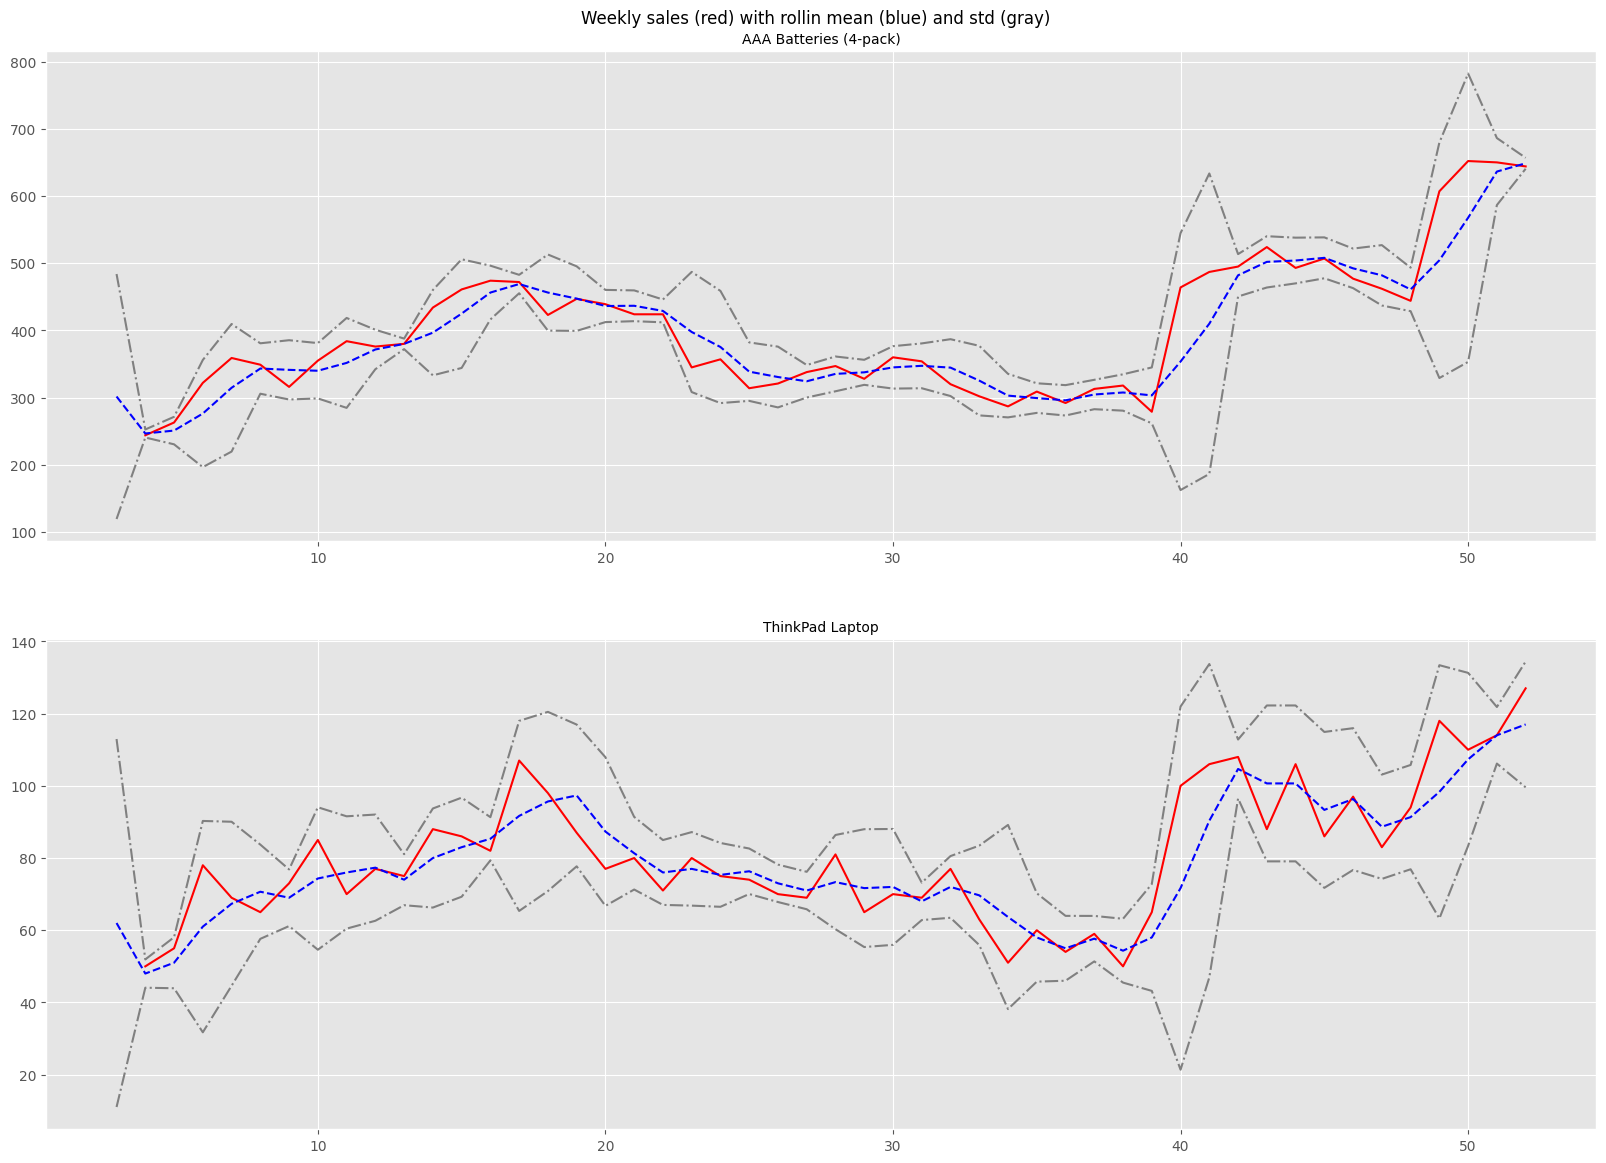

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(20, 14))
axes = axes.flatten()
for product, ax in zip(df.Product.unique(), axes):
#     pass
    sales, rol, ub, lb = moving_average(product, 3)
    ax.plot(sales, 'r');
    ax.plot(rol, 'b--')
    ax.plot(ub, c='gray', ls='-.')
    ax.plot(lb, c='gray', ls='-.')
    ax.set_title(product, fontsize=10)
fig.suptitle('Weekly sales (red) with rollin mean (blue) and std (gray)', y=.91, x=.51);

In [27]:
df.head()

Product  Quantity  Year  Month  Day        Date  Week  \
20  AAA Batteries (4-pack)         1  2019      4  117  2019-04-27    17   
28  AAA Batteries (4-pack)         2  2019      4  110  2019-04-20    16   
32  AAA Batteries (4-pack)         2  2019      4  100  2019-04-10    15   
45  AAA Batteries (4-pack)         2  2019      4  111  2019-04-21    16   
54  AAA Batteries (4-pack)         2  2019      4  108  2019-04-18    16   

            City_State  prices  
20  New York City (NY)    2.99  
28       Portland (OR)    5.98  
32  San Francisco (CA)    5.98  
45  San Francisco (CA)    5.98  
54         Boston (MA)    5.98

In [28]:
df_grouped = df.groupby(['City_State', 'Product', 'Date', 'Year'], as_index=False).agg({
    'Quantity': 'sum',
    'prices': 'sum',
    'Month': 'first',
    'Day': 'first',
    'Week': 'first',
})


In [29]:
df_grouped.head()

City_State                 Product        Date  Year  Quantity  prices  \
0  Atlanta (GA)  AAA Batteries (4-pack)  2019-01-01  2019         3    8.97   
1  Atlanta (GA)  AAA Batteries (4-pack)  2019-01-02  2019         3    8.97   
2  Atlanta (GA)  AAA Batteries (4-pack)  2019-01-03  2019         2    5.98   
3  Atlanta (GA)  AAA Batteries (4-pack)  2019-01-04  2019         3    8.97   
4  Atlanta (GA)  AAA Batteries (4-pack)  2019-01-05  2019         4   11.96   

   Month  Day  Week  
0      1    1     1  
1      1    2     1  
2      1    3     1  
3      1    4     1  
4      1    5     1

In [30]:
# df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])
# df = df.set_index('Date', drop=False)

In [31]:
colonnes_reordonnees = [
    'Date',
    'Year',
    'Month',
    'Day',
    'Week',
    'Product',
    'City_State',
    'prices',
    'Quantity'
]

# Appliquer le nouvel ordre
df_grouped = df_grouped[colonnes_reordonnees]

In [32]:
df_grouped.head()

Date  Year  Month  Day  Week                 Product    City_State  \
0  2019-01-01  2019      1    1     1  AAA Batteries (4-pack)  Atlanta (GA)   
1  2019-01-02  2019      1    2     1  AAA Batteries (4-pack)  Atlanta (GA)   
2  2019-01-03  2019      1    3     1  AAA Batteries (4-pack)  Atlanta (GA)   
3  2019-01-04  2019      1    4     1  AAA Batteries (4-pack)  Atlanta (GA)   
4  2019-01-05  2019      1    5     1  AAA Batteries (4-pack)  Atlanta (GA)   

   prices  Quantity  
0    8.97         3  
1    8.97         3  
2    5.98         2  
3    8.97         3  
4   11.96         4

In [33]:
df_grouped = df_grouped.sort_values(by=["Date"], ascending=True)
df_grouped.head()

Date  Year  Month  Day  Week                 Product  \
0     2019-01-01  2019      1    1     1  AAA Batteries (4-pack)   
2636  2019-01-01  2019      1    1     1         ThinkPad Laptop   
2271  2019-01-01  2019      1    1     1  AAA Batteries (4-pack)   
3798  2019-01-01  2019      1    1     1  AAA Batteries (4-pack)   
1698  2019-01-01  2019      1    1     1  AAA Batteries (4-pack)   

            City_State   prices  Quantity  
0         Atlanta (GA)     8.97         3  
2636  Los Angeles (CA)  4999.95         5  
2271  Los Angeles (CA)    23.92         8  
3798     Portland (OR)     2.99         1  
1698       Dallas (TX)    14.95         5

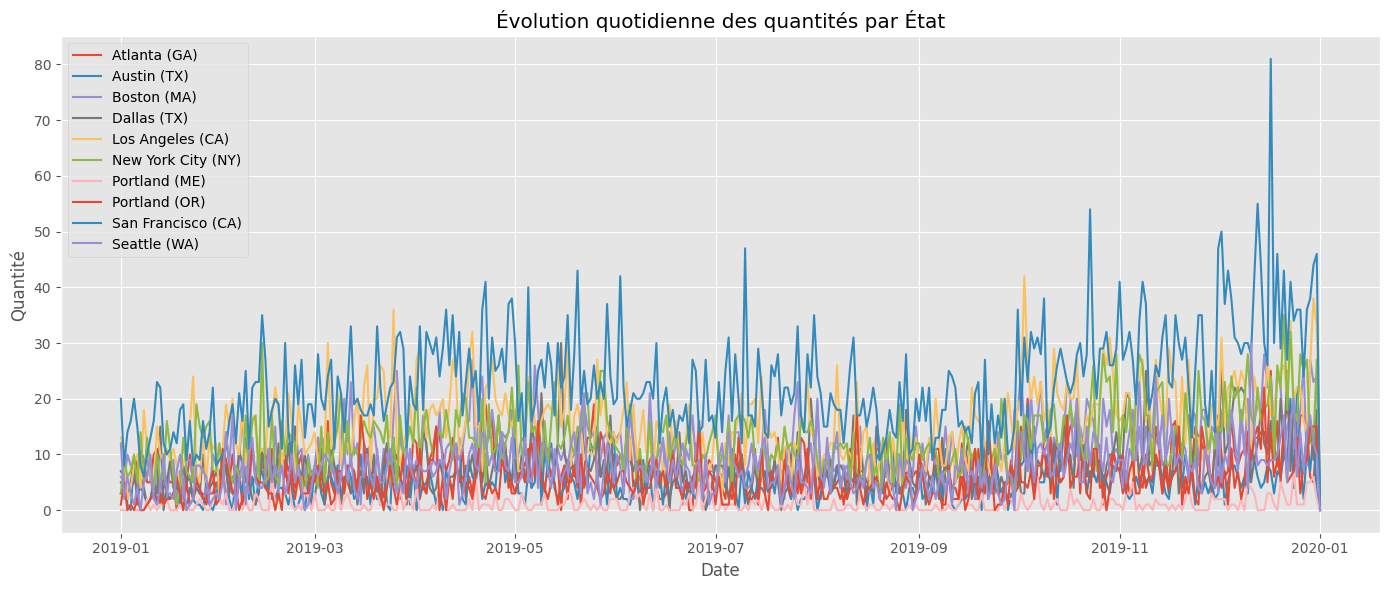

In [34]:
daily = df.groupby(["Date", "City_State"])["Quantity"].sum().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
for col in daily.columns:
    plt.plot(daily.index, daily[col], label=col)

plt.title("Évolution quotidienne des quantités par État")
plt.xlabel("Date")
plt.ylabel("Quantité")
plt.legend()
plt.tight_layout()
plt.show()

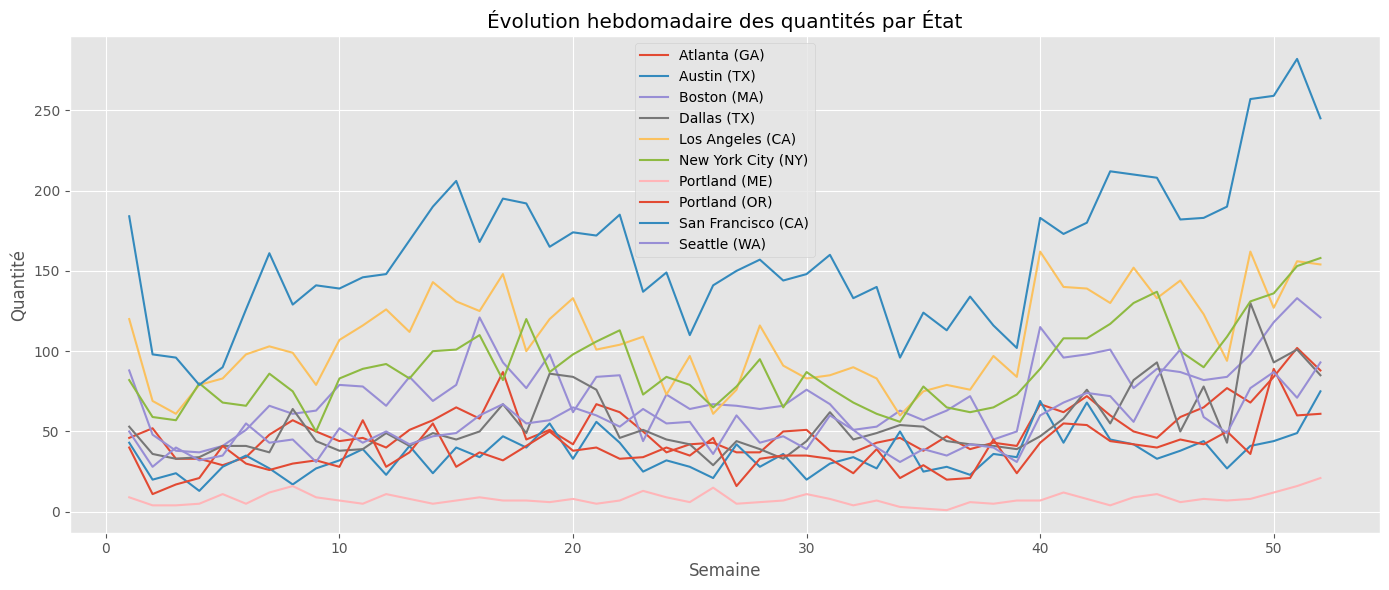

In [35]:

weekly = df.groupby(["Week", "City_State"])["Quantity"].sum().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
for col in weekly.columns:
    plt.plot(weekly.index, weekly[col], label=col)

plt.title("Évolution hebdomadaire des quantités par État")
plt.xlabel("Semaine")
plt.ylabel("Quantité")
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
df_grouped["prev_sales"] = df_grouped["Quantity"].shift(1)

In [37]:
df_grouped['prev_sales'] = df_grouped['prev_sales'].fillna(0)

In [38]:
df_grouped.head()

Date  Year  Month  Day  Week                 Product  \
0     2019-01-01  2019      1    1     1  AAA Batteries (4-pack)   
2636  2019-01-01  2019      1    1     1         ThinkPad Laptop   
2271  2019-01-01  2019      1    1     1  AAA Batteries (4-pack)   
3798  2019-01-01  2019      1    1     1  AAA Batteries (4-pack)   
1698  2019-01-01  2019      1    1     1  AAA Batteries (4-pack)   

            City_State   prices  Quantity  prev_sales  
0         Atlanta (GA)     8.97         3         0.0  
2636  Los Angeles (CA)  4999.95         5         3.0  
2271  Los Angeles (CA)    23.92         8         5.0  
3798     Portland (OR)     2.99         1         8.0  
1698       Dallas (TX)    14.95         5         1.0

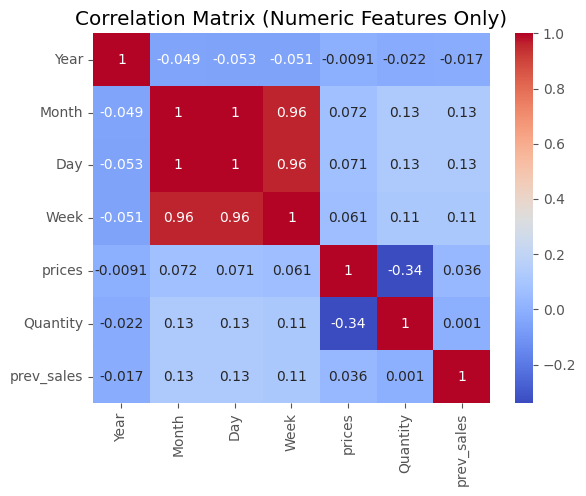

In [39]:
num_df = df_grouped.select_dtypes(include=['number'])
correlation_matrix = num_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features Only)')
plt.show()


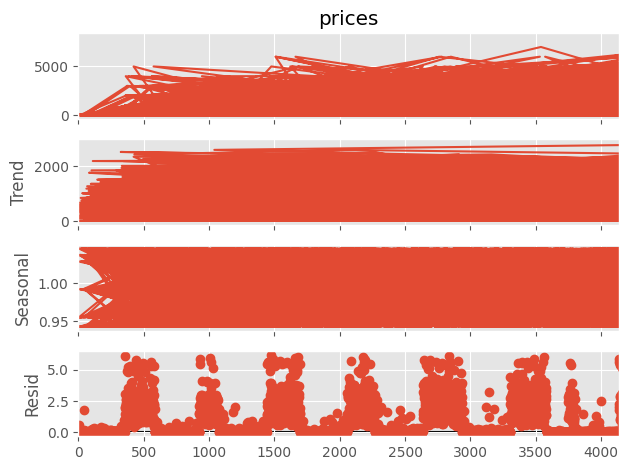

In [40]:
result = seasonal_decompose(df_grouped['prices'], model='multiplicative', period=6)
result.plot()
plt.show()

# Préparation des données

In [41]:
# Identifier les City_States par volume de commandes
city_states = df_grouped['City_State'].value_counts().head(10).index.tolist()

print("City_States:")
for i, city_state in enumerate(city_states, 1):
    count = df_grouped[df_grouped['City_State'] == city_state].shape[0]
    total_qty = df_grouped[df_grouped['City_State'] == city_state]['Quantity'].sum()
    print(f"  {i}. {city_state}: {count} commandes, {total_qty} unités")

City_States:
  1. San Francisco (CA): 704 commandes, 8371 unités
  2. Los Angeles (CA): 667 commandes, 5608 unités
  3. New York City (NY): 645 commandes, 4684 unités
  4. Boston (MA): 619 commandes, 3908 unités
  5. Atlanta (GA): 586 commandes, 2716 unités
  6. Dallas (TX): 573 commandes, 2849 unités
  7. Seattle (WA): 568 commandes, 2779 unités
  8. Portland (OR): 506 commandes, 1943 unités
  9. Austin (TX): 493 commandes, 1878 unités
  10. Portland (ME): 215 commandes, 411 unités


In [42]:
# Les 2 produits à analyser
products = ['ThinkPad Laptop', 'AAA Batteries (4-pack)']
print(f"\nProduits à analyser: {products}")


Produits à analyser: ['ThinkPad Laptop', 'AAA Batteries (4-pack)']


In [43]:
# # Création des séries temporelles quotidiennes (jours ouvrés) avec prix moyen
# time_series_data = {}

# for product in products:
#     for city_state in city_states:
#         # Filtrer les données
#         mask = (df_grouped['Product'] == product) & (df_grouped['City_State'] == city_state)
#         filtered_data = df_grouped[mask].copy()

#         if len(filtered_data) > 0:
#             # Série temporelle quotidienne (agrégation Quantity et prices)
#             ts_daily = filtered_data.groupby('Date')[['Quantity', 'prices']].sum().reset_index()
#             ts_daily['Date'] = pd.to_datetime(ts_daily['Date'])
#             ts_daily = ts_daily.set_index('Date')

#             # Fréquence jours ouvrés uniquement (Business days)
#             ts_daily = ts_daily.asfreq('B', fill_value=0)

#             # Prix unitaire moyen par jour
#             ts_daily['Average_Price'] = ts_daily['prices'] / ts_daily['Quantity']

#             # Prix moyen global du produit pour remplir les trous
#             mean_price = (
#                 df_grouped[df_grouped['Product'] == product]['prices'].sum() /
#                 df_grouped[df_grouped['Product'] == product]['Quantity'].sum()
#             )

#             # Corriger les NAN (jours sans ventes)
#             ts_daily['Average_Price'] = ts_daily['Average_Price'].ffill().fillna(mean_price)


#             # Garder seulement Quantity et Average_Price
#             ts_final = ts_daily[['Quantity', 'Average_Price']]

#             key = f"{product}_{city_state}"
#             time_series_data[key] = ts_final

#             print(f"✅ {product} - {city_state}: {len(ts_final)} jours ouvrés (Lun-Ven)")

# print(f"\nTotal de séries temporelles créées: {len(time_series_data)}")

In [44]:
# Création des séries temporelles quotidiennes (jours ouvrés) avec prix moyen
time_series_data = {}

for product in products:
    for city_state in city_states:
        mask = (df_grouped['Product'] == product) & (df_grouped['City_State'] == city_state)
        filtered_data = df_grouped[mask].copy()

        if len(filtered_data) > 0:
            ts_daily = (
                filtered_data.groupby('Date')[['Quantity', 'prices']]
                .sum()
                .reset_index()
            )
            ts_daily['Date'] = pd.to_datetime(ts_daily['Date'])
            ts_daily = ts_daily.set_index('Date')

            ts_daily = ts_daily.asfreq('B', fill_value=0)

            mean_price = (
                df_grouped[df_grouped['Product'] == product]['prices'].sum() /
                df_grouped[df_grouped['Product'] == product]['Quantity'].sum()
            )

            ts_daily['Average_Price'] = ts_daily.apply(
                lambda row: row['prices'] / row['Quantity'] if row['Quantity'] > 0 else np.nan,
                axis=1
            )

            # 1. Forward fill (propager dernier prix connu)
            # 2. Backward fill si série commence par des NaN
            # 3. Mean price si tout est NaN
            ts_daily['Average_Price'] = (
                ts_daily['Average_Price']
                .ffill()
                .bfill()
                .fillna(mean_price)
            )

            ts_final = ts_daily[['Quantity', 'Average_Price']]

            key = f"{product}_{city_state}"
            time_series_data[key] = ts_final

            print(f"✅ {product} - {city_state}: {len(ts_final)} jours ouvrés (Lun-Ven)")

print(f"\nTotal de séries temporelles créées: {len(time_series_data)}")


✅ ThinkPad Laptop - San Francisco (CA): 261 jours ouvrés (Lun-Ven)
✅ ThinkPad Laptop - Los Angeles (CA): 262 jours ouvrés (Lun-Ven)
✅ ThinkPad Laptop - New York City (NY): 260 jours ouvrés (Lun-Ven)
✅ ThinkPad Laptop - Boston (MA): 261 jours ouvrés (Lun-Ven)
✅ ThinkPad Laptop - Atlanta (GA): 260 jours ouvrés (Lun-Ven)
✅ ThinkPad Laptop - Dallas (TX): 260 jours ouvrés (Lun-Ven)
✅ ThinkPad Laptop - Seattle (WA): 261 jours ouvrés (Lun-Ven)
✅ ThinkPad Laptop - Portland (OR): 260 jours ouvrés (Lun-Ven)
✅ ThinkPad Laptop - Austin (TX): 259 jours ouvrés (Lun-Ven)
✅ ThinkPad Laptop - Portland (ME): 251 jours ouvrés (Lun-Ven)
✅ AAA Batteries (4-pack) - San Francisco (CA): 262 jours ouvrés (Lun-Ven)
✅ AAA Batteries (4-pack) - Los Angeles (CA): 261 jours ouvrés (Lun-Ven)
✅ AAA Batteries (4-pack) - New York City (NY): 262 jours ouvrés (Lun-Ven)
✅ AAA Batteries (4-pack) - Boston (MA): 261 jours ouvrés (Lun-Ven)
✅ AAA Batteries (4-pack) - Atlanta (GA): 261 jours ouvrés (Lun-Ven)
✅ AAA Batteries (4-p

In [45]:
# Split Train/Test basé sur une date fixe (mi-novembre 2019)

# Date de référence pour le split
# Le 15 novembre 2019 est un vendredi
SPLIT_DATE = pd.Timestamp('2019-11-15')

print(f"📅 Date de split: {SPLIT_DATE.strftime('%d %B %Y')} (vendredi)")
print(f"   Train: Jours ouvrés AVANT le {SPLIT_DATE.strftime('%d/%m/%Y')}")
print(f"   Test: Jours ouvrés À PARTIR du {SPLIT_DATE.strftime('%d/%m/%Y')}")
print(f"   Note: Pas de week-ends dans les données!")

📅 Date de split: 15 November 2019 (vendredi)
   Train: Jours ouvrés AVANT le 15/11/2019
   Test: Jours ouvrés À PARTIR du 15/11/2019
   Note: Pas de week-ends dans les données!


In [46]:
train_test_splits = {}
first_split = True

for key, ts in time_series_data.items():
    # Train < SPLIT_DATE, Test >= SPLIT_DATE
    train = ts[ts.index < SPLIT_DATE].copy()
    test = ts[ts.index >= SPLIT_DATE].copy()

    # Vérifier qu'on a des données dans les deux ensembles
    if len(train) == 0 or len(test) == 0:
        print(f"⚠️  {key}: Pas assez de données pour le split")
        continue

    train_test_splits[key] = {
        'train': train,
        'test': test,
        'full': ts
    }

    # Afficher seulement un exemple détaillé
    if first_split:
        print(f"✅ {key} (exemple détaillé)")
        print(f"   Train: {train.index.min().strftime('%Y-%m-%d')} à {train.index.max().strftime('%Y-%m-%d')} ({len(train)} jours)")
        print(f"   Test: {test.index.min().strftime('%Y-%m-%d')} à {test.index.max().strftime('%Y-%m-%d')} ({len(test)} jours)")

        train_ratio = len(train) / len(ts) * 100
        test_ratio = len(test) / len(ts) * 100
        print(f"   Ratio: Train {train_ratio:.1f}% / Test {test_ratio:.1f}%")
        first_split = False
    else:
        train_ratio = len(train) / len(ts) * 100
        print(f"✅ {key}: {len(train)} train / {len(test)} test ({train_ratio:.0f}%/{100-train_ratio:.0f}%)")


✅ ThinkPad Laptop_San Francisco (CA) (exemple détaillé)
   Train: 2019-01-01 à 2019-11-14 (228 jours)
   Test: 2019-11-15 à 2019-12-31 (33 jours)
   Ratio: Train 87.4% / Test 12.6%
✅ ThinkPad Laptop_Los Angeles (CA): 228 train / 34 test (87%/13%)
✅ ThinkPad Laptop_New York City (NY): 227 train / 33 test (87%/13%)
✅ ThinkPad Laptop_Boston (MA): 227 train / 34 test (87%/13%)
✅ ThinkPad Laptop_Atlanta (GA): 227 train / 33 test (87%/13%)
✅ ThinkPad Laptop_Dallas (TX): 227 train / 33 test (87%/13%)
✅ ThinkPad Laptop_Seattle (WA): 228 train / 33 test (87%/13%)
✅ ThinkPad Laptop_Portland (OR): 227 train / 33 test (87%/13%)
✅ ThinkPad Laptop_Austin (TX): 227 train / 32 test (88%/12%)
✅ ThinkPad Laptop_Portland (ME): 220 train / 31 test (88%/12%)
✅ AAA Batteries (4-pack)_San Francisco (CA): 228 train / 34 test (87%/13%)
✅ AAA Batteries (4-pack)_Los Angeles (CA): 228 train / 33 test (87%/13%)
✅ AAA Batteries (4-pack)_New York City (NY): 228 train / 34 test (87%/13%)
✅ AAA Batteries (4-pack)_Bost

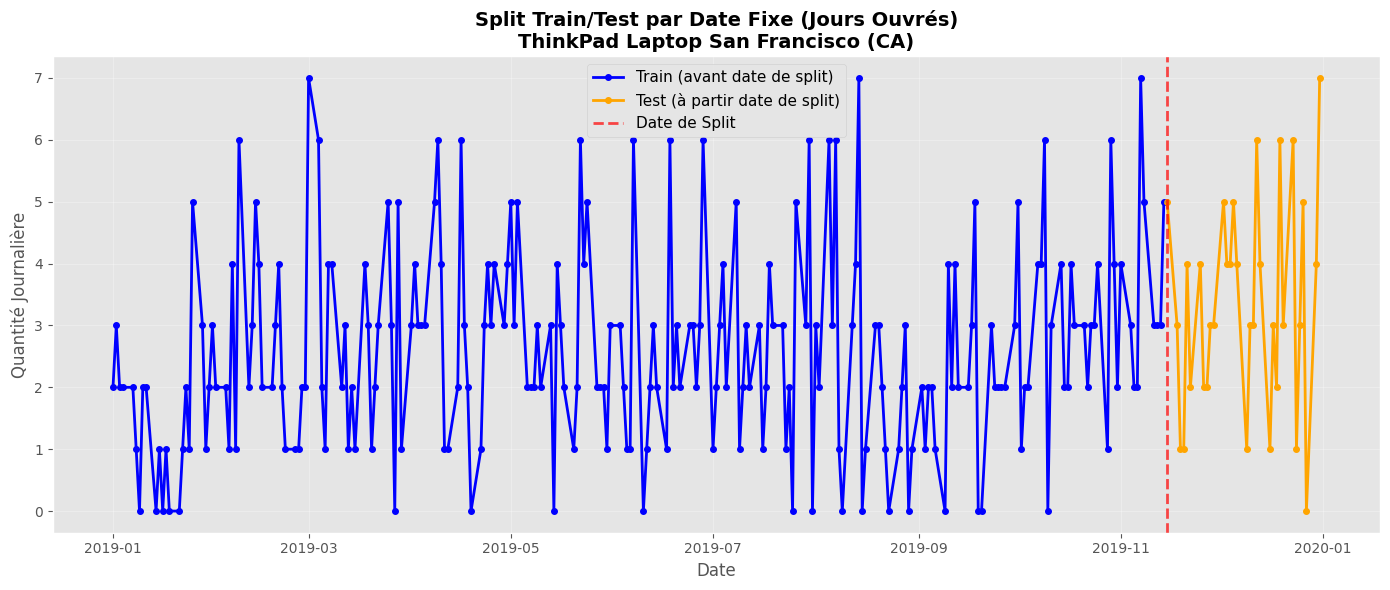

In [47]:
# Visualisation d'un exemple de split
example_key = list(train_test_splits.keys())[0]
example_data = train_test_splits[example_key]

plt.figure(figsize=(14, 6))

plt.plot(example_data['train'].index, example_data['train']['Quantity'],
         label='Train (avant date de split)', color='blue', linewidth=2, marker='o', markersize=4)

plt.plot(example_data['test'].index, example_data['test']['Quantity'],
         label='Test (à partir date de split)', color='orange', linewidth=2, marker='o', markersize=4)

# Relier visuellement train et test
if len(example_data['train']) > 0 and len(example_data['test']) > 0:
    last_train_date = example_data['train'].index[-1]
    last_train_value = example_data['train']['Quantity'].iloc[-1]
    first_test_date = example_data['test'].index[0]
    first_test_value = example_data['test']['Quantity'].iloc[0]

    plt.plot([last_train_date, first_test_date],
             [last_train_value, first_test_value],
             color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

plt.axvline(x=SPLIT_DATE, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Date de Split')

plt.title(f"Split Train/Test par Date Fixe (Jours Ouvrés)\n{example_key.replace('_', ' ')}", fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantité Journalière', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [48]:
# Statistiques récapitulatives des splits
split_stats = []
for key, data in train_test_splits.items():
    split_stats.append({
        'Serie': key,
        'Train_Days': len(data['train']),
        'Test_Days': len(data['test']),
        'Train_Mean': data['train']['Quantity'].mean(),
        'Test_Mean': data['test']['Quantity'].mean(),
        'Total_Sales': data['full']['Quantity'].sum()
    })

split_stats_df = pd.DataFrame(split_stats).sort_values('Total_Sales', ascending=False)
print("\nStatistiques des splits (Jours Ouvrés):")
print(split_stats_df.to_string(index=False))



Statistiques des splits (Jours Ouvrés):
                                    Serie  Train_Days  Test_Days  Train_Mean  Test_Mean  Total_Sales
AAA Batteries (4-pack)_San Francisco (CA)         228         34   18.785088  31.088235         5340
  AAA Batteries (4-pack)_Los Angeles (CA)         228         33   13.021930  18.424242         3577
AAA Batteries (4-pack)_New York City (NY)         228         34   10.754386  16.088235         2999
       AAA Batteries (4-pack)_Boston (MA)         228         33    9.149123  13.575758         2534
       AAA Batteries (4-pack)_Dallas (TX)         228         33    6.280702  10.666667         1784
      AAA Batteries (4-pack)_Seattle (WA)         228         33    6.276316   9.060606         1730
      AAA Batteries (4-pack)_Atlanta (GA)         228         33    5.842105   9.212121         1636
     AAA Batteries (4-pack)_Portland (OR)         228         34    4.258772   6.882353         1205
       AAA Batteries (4-pack)_Austin (TX)         

# Sélection de modèle

## ARIMA

In [49]:
# Fonctions ARIMA
def add_connection_line(train_data, test_data):
    """Ajoute une ligne de connexion entre train et test pour éviter l'espace blanc"""
    if len(train_data) > 0 and len(test_data) > 0:
        last_train_date = train_data.index[-1]
        last_train_value = train_data['Quantity'].iloc[-1]
        first_test_date = test_data.index[0]
        first_test_value = test_data['Quantity'].iloc[0]

        plt.plot([last_train_date, first_test_date],
                 [last_train_value, first_test_value],
                 color='gray', linestyle=':', linewidth=1.5, alpha=0.5)


def train_arima(train_data, order=(7, 1, 2)):
    """Entraîne un modèle ARIMA optimisé pour données volatiles"""
    train_values = np.array(train_data['Quantity'].values, dtype=np.float64) + 0.1
    model = ARIMA(train_values, order=order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    return model_fit


def predict_arima(model_fit, steps):
    """Fait des prédictions avec ARIMA"""
    forecast = model_fit.forecast(steps=steps)
    forecast = np.maximum(forecast - 0.1, 0)
    return forecast


🔹 Test ARIMA sur un exemple:
   Taille train: 228 jours
   Taille test: 33 jours
✅ ARIMA entraîné avec succès!
   Meilleur ordre: (5, 1, 2)
   RMSE: 1.70
   MAE: 1.40


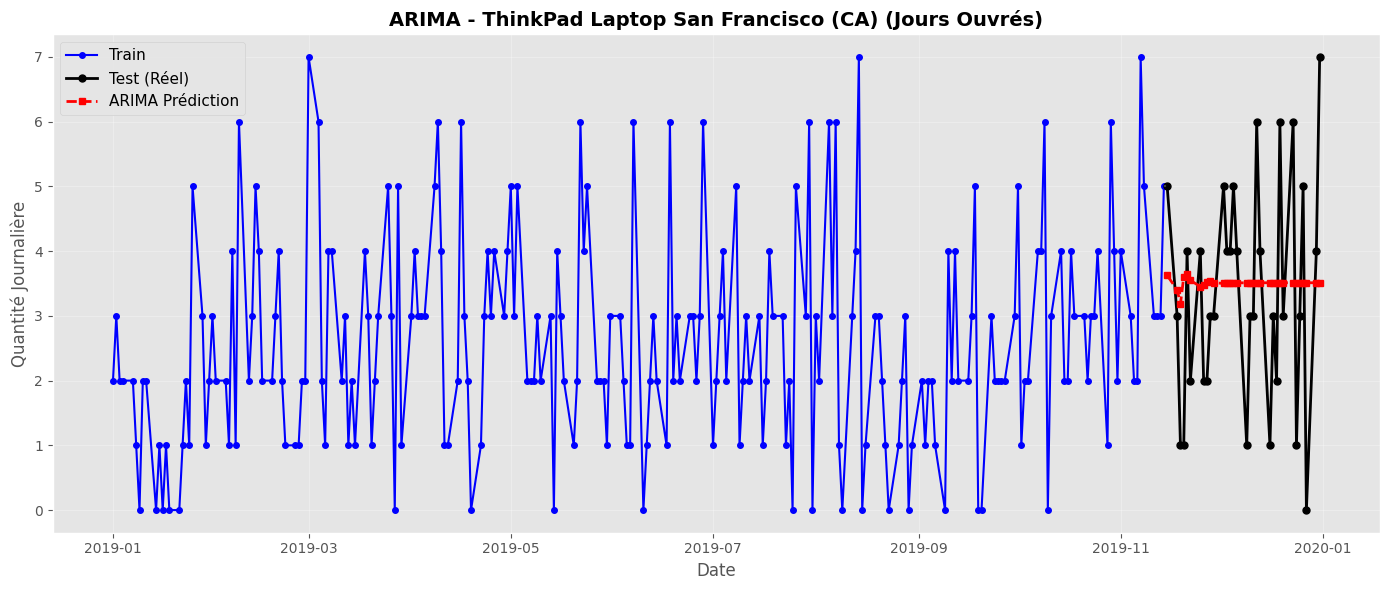

In [50]:
# Test ARIMA sur un exemple de série

example_key = list(train_test_splits.keys())[0]
example_train = train_test_splits[example_key]['train']
example_test = train_test_splits[example_key]['test']

print("🔹 Test ARIMA sur un exemple:")
print(f"   Taille train: {len(example_train)} jours")
print(f"   Taille test: {len(example_test)} jours")

best_rmse = float('inf')
best_model = None
best_order = None
arima_pred = None

orders_to_test = [(7, 1, 2), (5, 1, 2), (3, 1, 1), (2, 1, 0)]

for order in orders_to_test:
    try:
        temp_model = train_arima(example_train, order=order)
        temp_pred = predict_arima(temp_model, len(example_test))

        if len(temp_pred) != len(example_test):
            print(f"Ordre {order}: longueur prédiction {len(temp_pred)} != test {len(example_test)}")
            continue

        temp_rmse = np.sqrt(mean_squared_error(example_test['Quantity'], temp_pred))

        if temp_rmse < best_rmse:
            best_rmse = temp_rmse
            best_model = temp_model
            best_order = order
            arima_pred = temp_pred
    except Exception as e:
        print(f"Ordre {order} échoué: {e}")
        continue

if arima_pred is None or best_model is None:
    raise Exception("Aucun ordre ARIMA n'a fonctionné")

rmse = np.sqrt(mean_squared_error(example_test['Quantity'], arima_pred))
mae = mean_absolute_error(example_test['Quantity'], arima_pred)

print(f"✅ ARIMA entraîné avec succès!")
print(f"   Meilleur ordre: {best_order}")
print(f"   RMSE: {rmse:.2f}")
print(f"   MAE: {mae:.2f}")

plt.figure(figsize=(14, 6))
plt.plot(example_train.index, example_train['Quantity'], label='Train', color='blue', marker='o', markersize=4)
plt.plot(example_test.index, example_test['Quantity'], label='Test (Réel)', color='black', linewidth=2, marker='o', markersize=5)
plt.plot(example_test.index, arima_pred, label='ARIMA Prédiction', color='red', linestyle='--', linewidth=2, marker='s', markersize=5)

add_connection_line(example_train, example_test)

plt.title(f"ARIMA - {example_key.replace('_', ' ')} (Jours Ouvrés)", fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantité Journalière', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## PROPHET

In [51]:
# Fonctions Prophet

import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

try:
    from prophet import Prophet
except ImportError:
    from fbprophet import Prophet


def train_prophet(train_data):
    """Entraîne un modèle Prophet robuste"""
    prophet_df = train_data.reset_index().rename(columns={'Date': 'ds', 'Quantity': 'y'})

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.5,
    )
    model.add_country_holidays(country_name='US')
    model.fit(prophet_df)
    return model


def predict_prophet(model, steps):
    """Fait des prédictions avec Prophet (jours ouvrés uniquement)"""
    future = model.make_future_dataframe(periods=steps, freq='B')
    forecast = model.predict(future)
    predictions = forecast.iloc[-steps:]['yhat'].values
    predictions = np.maximum(predictions, 0)
    return predictions



🔹 Test Prophet sur le même exemple:
✅ Prophet entraîné avec succès!
   RMSE: 3.09
   MAE: 2.42


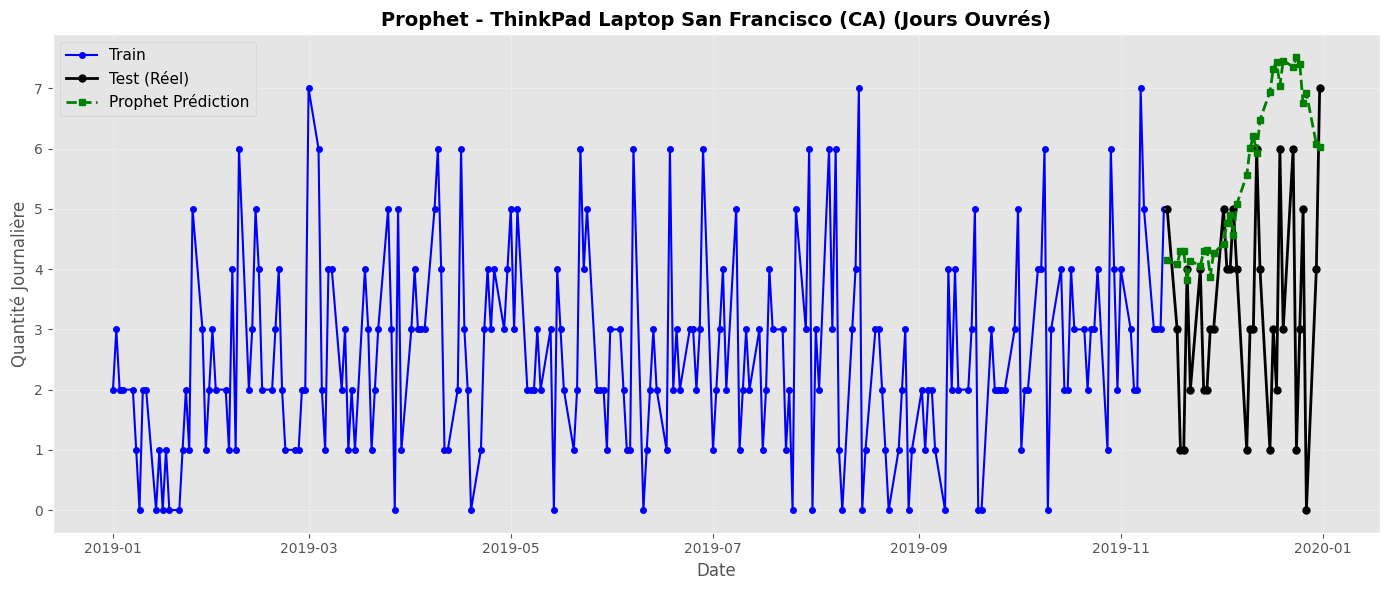

In [52]:
# Test Prophet sur le même exemple de série

example_key = list(train_test_splits.keys())[0]
example_train = train_test_splits[example_key]['train']
example_test = train_test_splits[example_key]['test']

print("\n🔹 Test Prophet sur le même exemple:")

try:
    prophet_model = train_prophet(example_train)
    prophet_pred = predict_prophet(prophet_model, len(example_test))

    rmse = np.sqrt(mean_squared_error(example_test['Quantity'], prophet_pred))
    mae = mean_absolute_error(example_test['Quantity'], prophet_pred)

    print(f"✅ Prophet entraîné avec succès!")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAE: {mae:.2f}")

    plt.figure(figsize=(14, 6))
    plt.plot(example_train.index, example_train['Quantity'], label='Train', color='blue', marker='o', markersize=4)
    plt.plot(example_test.index, example_test['Quantity'], label='Test (Réel)', color='black', linewidth=2, marker='o', markersize=5)
    plt.plot(example_test.index, prophet_pred, label='Prophet Prédiction', color='green', linestyle='--', linewidth=2, marker='s', markersize=5)

    add_connection_line(example_train, example_test)

    plt.title(f"Prophet - {example_key.replace('_', ' ')} (Jours Ouvrés)", fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Quantité Journalière', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"❌ Erreur Prophet: {e}")


## XGBOOST

In [53]:
def create_features(df):
    """Crée des features pour le machine learning (série temporelle quotidienne ouvrée)"""
    df = df.copy()
    df['lag_1'] = df['Quantity'].shift(1)
    df['lag_2'] = df['Quantity'].shift(2)
    df['lag_3'] = df['Quantity'].shift(3)
    df['lag_7'] = df['Quantity'].shift(7)  # J-7 (même jour de la semaine précédente)

    # Moyennes mobiles
    df['rolling_mean_3'] = df['Quantity'].shift(1).rolling(window=3).mean()
    df['rolling_mean_7'] = df['Quantity'].shift(1).rolling(window=7).mean()

    # Max et écart-type mobiles pour capturer les pics
    df['rolling_max_7'] = df['Quantity'].shift(1).rolling(window=7).max()
    df['rolling_std_7'] = df['Quantity'].shift(1).rolling(window=7).std()

    # Features calendaires
    df['month'] = df.index.month
    df['week_of_year'] = df.index.isocalendar().week.astype(int)
    df['day_of_week'] = df.index.dayofweek
    df['is_Q4'] = df['month'].apply(lambda x: 1 if x >= 10 else 0)

    # Tendance
    df['time_idx'] = df.index.map(pd.Timestamp.toordinal)

    # Prix moyen comme feature explicative
    if 'Average_Price' in df.columns:
        df['price'] = df['Average_Price']
    else:
        df['price'] = 0

    return df.dropna()


In [54]:
def train_xgboost(
    train_data,
    n_estimators=100,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    subsample=0.9,
    tune_hyperparameters=False
):
    train_features = create_features(train_data)

    feature_cols = [
        'lag_1', 'lag_2', 'lag_3', 'lag_7',
        'rolling_mean_3', 'rolling_mean_7',
        'rolling_max_7', 'rolling_std_7',
        'month', 'week_of_year', 'day_of_week', 'is_Q4',
        'price', 'time_idx',
    ]
    target = 'Quantity'

    X_train = train_features[feature_cols]
    y_train = train_features[target]

    if tune_hyperparameters:
        print("   ⚡ Optimisation des hyperparamètres XGBoost en cours...")
        tscv = TimeSeriesSplit(n_splits=3)

        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3],
            'subsample': [0.7, 0.8, 0.9],
        }

        xgb = XGBRegressor(random_state=42, verbosity=0)
        grid_search = GridSearchCV(
            estimator=xgb,
            param_grid=param_grid,
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            verbose=0,
            n_jobs=-1,
        )
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
        print(f"   ✅ Meilleurs paramètres: {grid_search.best_params_}")
    else:
        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            random_state=42,
            verbosity=0,
        )
        model.fit(X_train, y_train)

    return model, feature_cols

In [55]:
def predict_xgboost(model, train_data, test_data, feature_cols):
    """Fait des prédictions avec XGBoost"""
    full_data = pd.concat([train_data, test_data])
    full_features = create_features(full_data)

    test_features = full_features.loc[test_data.index]

    if len(test_features) > 0:
        X_test = test_features[feature_cols]
        predictions = model.predict(X_test)
        predictions = np.maximum(predictions, 0)
        return predictions
    else:
        return np.array([])



🔹 Test XGBoost sur le même exemple:
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
✅ XGBoost entraîné avec succès!
   RMSE: 1.68
   MAE: 1.38


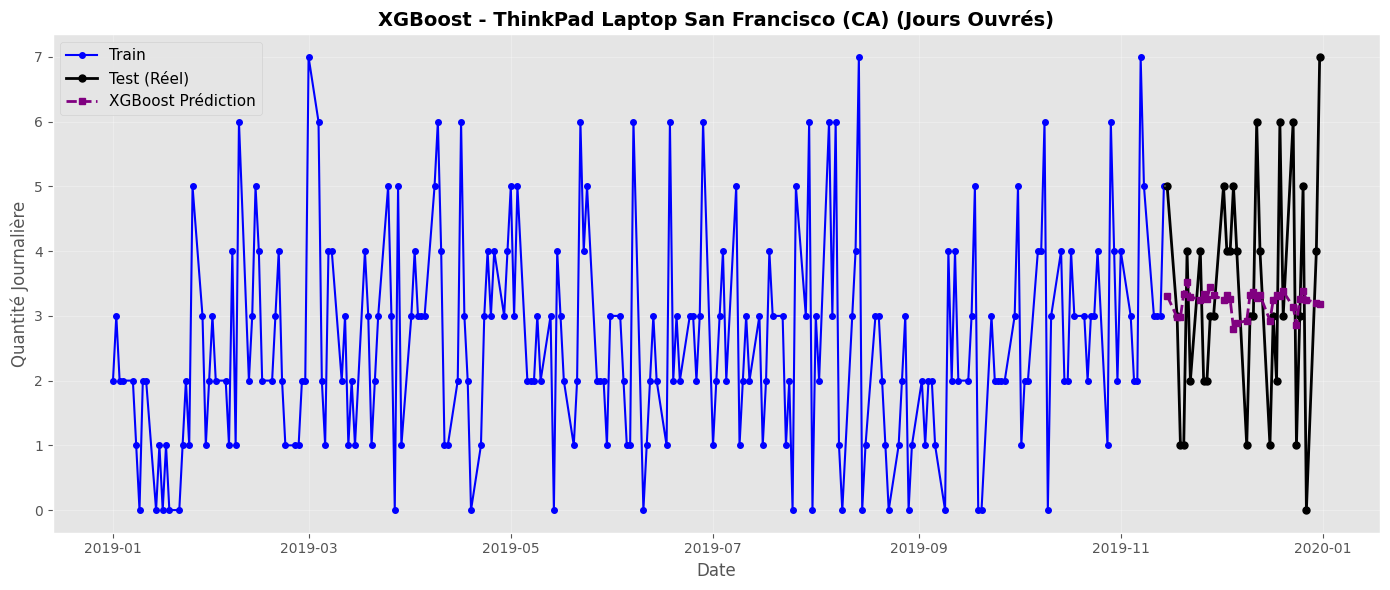

In [56]:
# Test XGBoost sur le même exemple de série

example_key = list(train_test_splits.keys())[0]
example_train = train_test_splits[example_key]['train']
example_test = train_test_splits[example_key]['test']

print("\n🔹 Test XGBoost sur le même exemple:")

try:
    xgb_model, feature_cols = train_xgboost(example_train, n_estimators=50, tune_hyperparameters=True)
    xgb_pred = predict_xgboost(xgb_model, example_train, example_test, feature_cols)

    rmse = np.sqrt(mean_squared_error(example_test['Quantity'].iloc[:len(xgb_pred)], xgb_pred))
    mae = mean_absolute_error(example_test['Quantity'].iloc[:len(xgb_pred)], xgb_pred)

    print(f"✅ XGBoost entraîné avec succès!")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAE: {mae:.2f}")

    plt.figure(figsize=(14, 6))
    plt.plot(example_train.index, example_train['Quantity'], label='Train', color='blue', marker='o', markersize=4)
    plt.plot(example_test.index, example_test['Quantity'], label='Test (Réel)', color='black', linewidth=2, marker='o', markersize=5)

    test_dates = example_test.index[:len(xgb_pred)]
    plt.plot(test_dates, xgb_pred, label='XGBoost Prédiction', color='purple', linestyle='--', linewidth=2, marker='s', markersize=5)

    add_connection_line(example_train, example_test)

    plt.title(f"XGBoost - {example_key.replace('_', ' ')} (Jours Ouvrés)", fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Quantité Journalière', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"❌ Erreur XGBoost: {e}")

# Amélioration du modele

Parmis les modeles testé, on a décider de garder XGBOOST

In [57]:
def analyze_all_series(train_test_splits, model_type='xgboost', use_fallback=True):
    results = {}

    for key, data in train_test_splits.items():
        train = data['train']
        test = data['test']

        print(f"\n🔹 Analyse: {key}")

        model_used = model_type
        success = False

        try:
            if model_type == 'arima':
                model = train_arima(train, order=(2, 1, 0))
                predictions = predict_arima(model, len(test))
                success = True
            elif model_type == 'prophet':
                model = train_prophet(train)
                predictions = predict_prophet(model, len(test))
                success = True
            elif model_type == 'xgboost':
                model, feature_cols = train_xgboost(train, n_estimators=50, tune_hyperparameters=True)
                predictions = predict_xgboost(model, train, test, feature_cols)
                success = True
        except Exception as e:
            print(f"{model_type.upper()} échoué: {str(e)[:50]}...")

            if model_type == 'xgboost':
                print("Tentative XGBoost sans tuning...")
                try:
                    model, feature_cols = train_xgboost(train, n_estimators=50, tune_hyperparameters=False)
                    predictions = predict_xgboost(model, train, test, feature_cols)
                    model_used = 'xgboost (standard)'
                    success = True
                except Exception as e3:
                    print(f"XGBoost standard échoué aussi: {str(e3)[:50]}...")
            elif use_fallback:
                print("Fallback vers XGBoost...")
                try:
                    model, feature_cols = train_xgboost(train, n_estimators=50, tune_hyperparameters=False)
                    predictions = predict_xgboost(model, train, test, feature_cols)
                    model_used = 'xgboost (fallback)'
                    success = True
                except Exception as e2:
                    print(f"XGBoost échoué aussi: {str(e2)[:50]}...")

        if success:
            try:
                y_true = test['Quantity'].iloc[:len(predictions)]
                rmse = np.sqrt(mean_squared_error(y_true, predictions))
                mae = mean_absolute_error(y_true, predictions)

                results[key] = {
                    'model': model,
                    'model_type': model_used,
                    'predictions': predictions,
                    'rmse': rmse,
                    'mae': mae,
                    'total_sales': data['full']['Quantity'].sum(),
                    'avg_sales': data['full']['Quantity'].mean(),
                }

                print(f"=>{model_used.upper()} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

                plt.figure(figsize=(12, 5))
                plt.plot(train.index, train['Quantity'], label='Train', color='blue', alpha=0.6)
                plt.plot(test.index, test['Quantity'], label='Test (Réel)', color='black', linewidth=2)

                if 'xgboost' in model_used.lower():
                    test_dates = test.index[:len(predictions)]
                    plt.plot(test_dates, predictions, label=f'{model_used} Prédiction', color='red', linestyle='--', linewidth=2)
                else:
                    plt.plot(test.index, predictions, label=f'{model_used} Prédiction', color='red', linestyle='--', linewidth=2)

                plt.title(f"Prédiction pour {key.replace('_', ' ')} (RMSE: {rmse:.2f})", fontsize=12, fontweight='bold')
                plt.xlabel('Date')
                plt.ylabel('Quantité')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Erreur d'évaluation: {e}")
                results[key] = None
        else:
            results[key] = None

    return results




ANALYSE COMPLÈTE AVEC XGBOOST
ℹ️  XGBoost est utilisé comme modèle principal

🔹 Analyse: ThinkPad Laptop_San Francisco (CA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
=>XGBOOST - RMSE: 1.68, MAE: 1.38


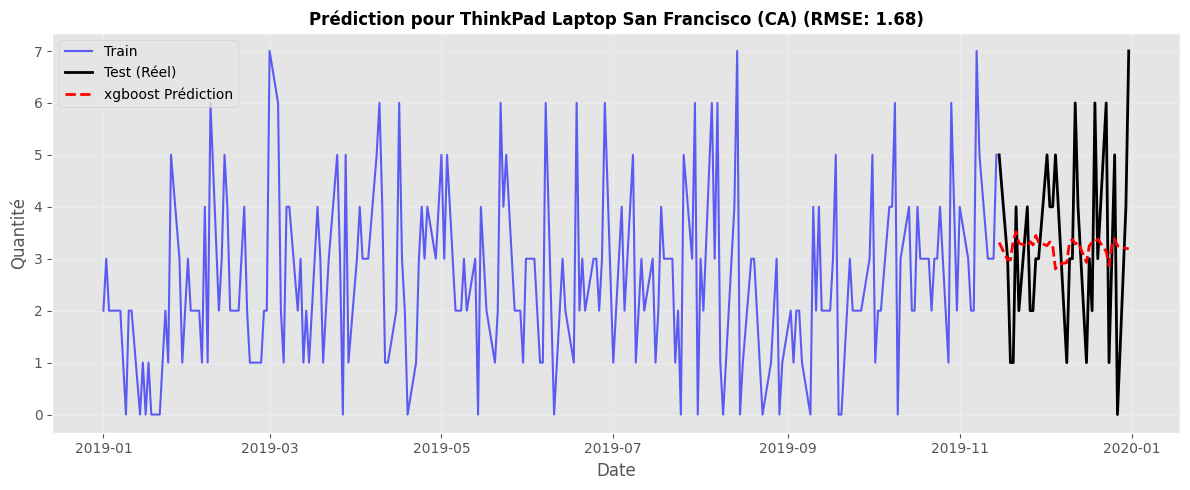


🔹 Analyse: ThinkPad Laptop_Los Angeles (CA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
=>XGBOOST - RMSE: 1.27, MAE: 1.02


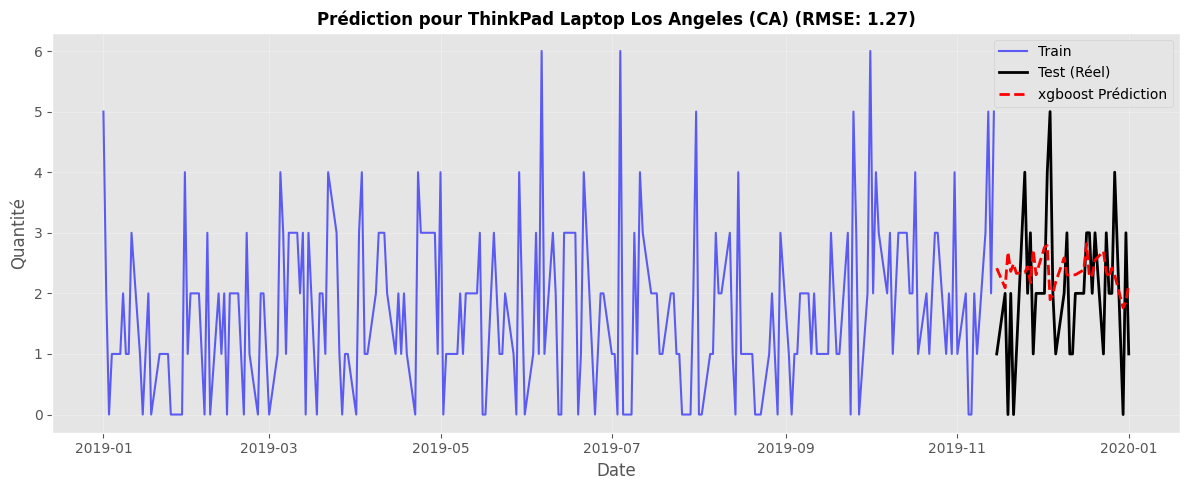


🔹 Analyse: ThinkPad Laptop_New York City (NY)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
=>XGBOOST - RMSE: 1.99, MAE: 1.60


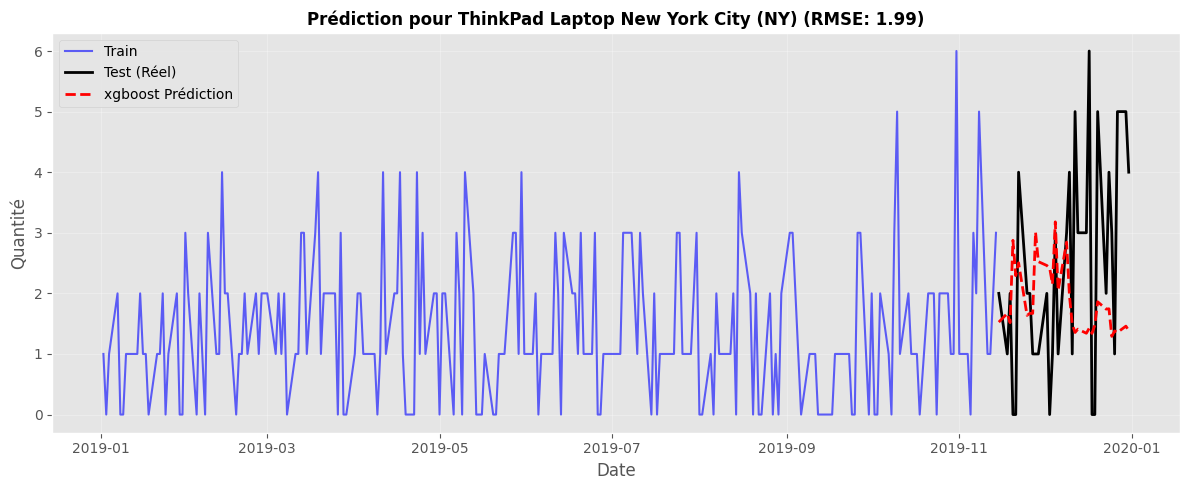


🔹 Analyse: ThinkPad Laptop_Boston (MA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
=>XGBOOST - RMSE: 1.33, MAE: 0.86


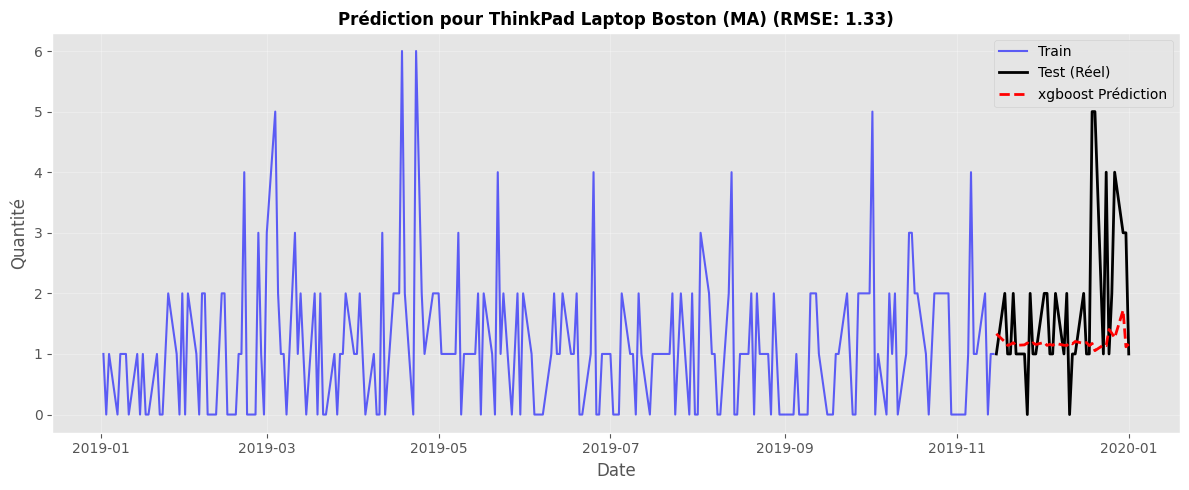


🔹 Analyse: ThinkPad Laptop_Atlanta (GA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 1.45, MAE: 1.11


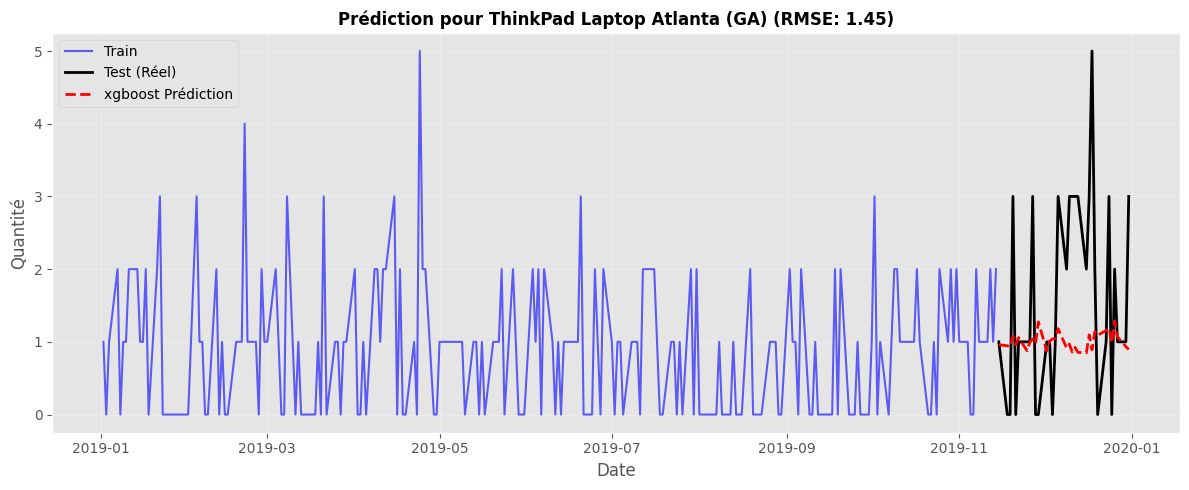


🔹 Analyse: ThinkPad Laptop_Dallas (TX)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 1.12, MAE: 0.93


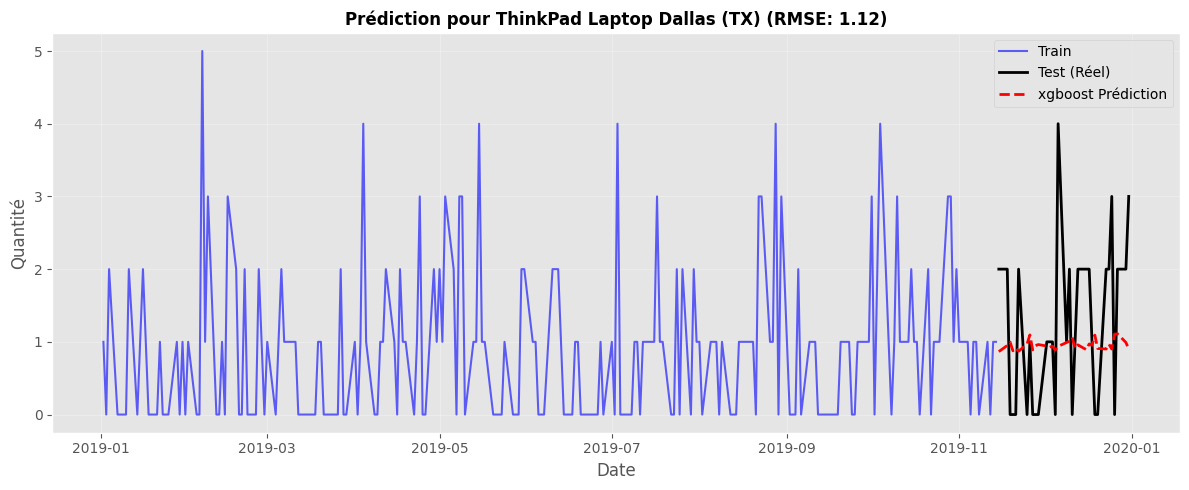


🔹 Analyse: ThinkPad Laptop_Seattle (WA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
=>XGBOOST - RMSE: 1.43, MAE: 1.12


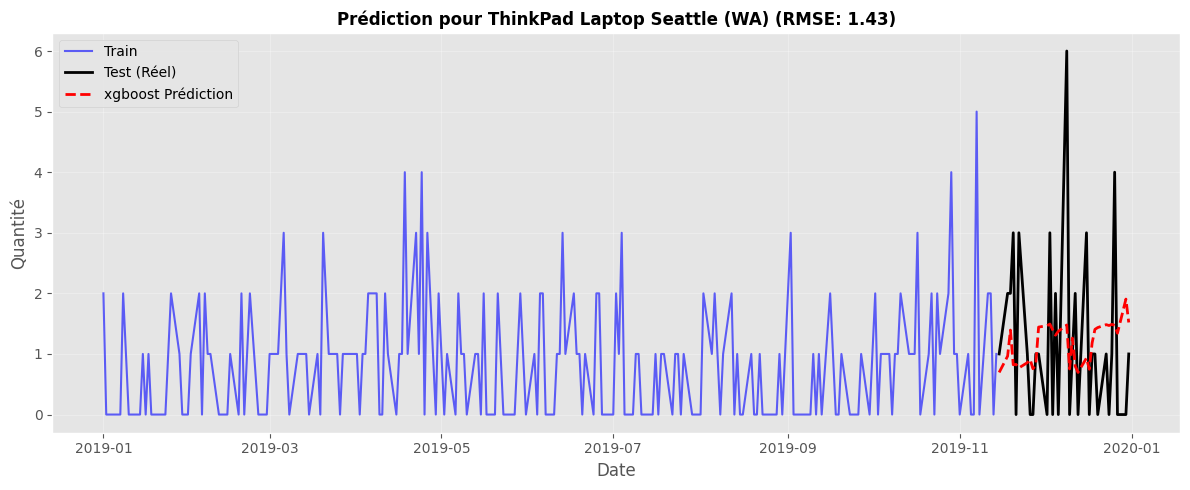


🔹 Analyse: ThinkPad Laptop_Portland (OR)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 1.43, MAE: 0.93


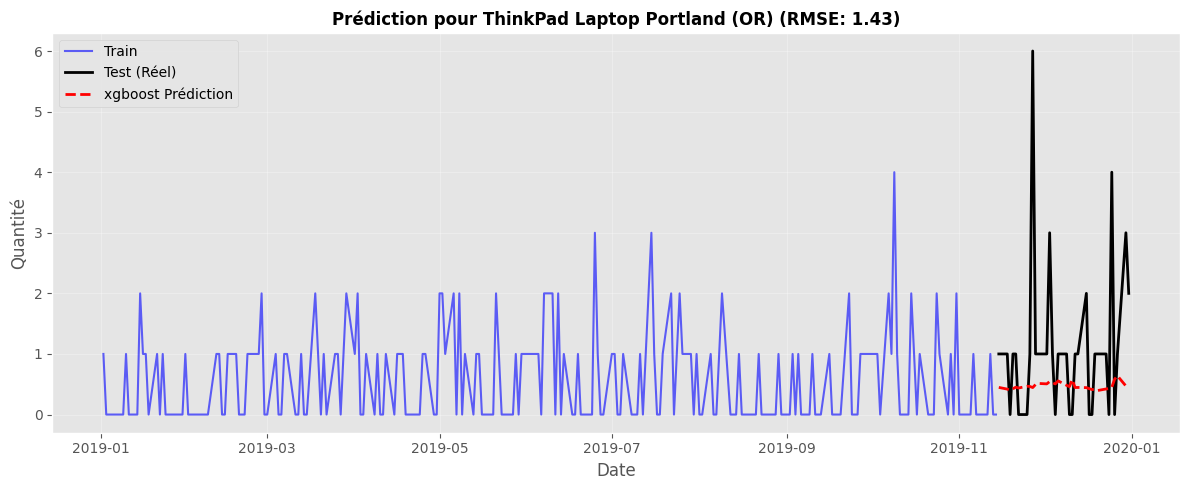


🔹 Analyse: ThinkPad Laptop_Austin (TX)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 1.17, MAE: 0.91


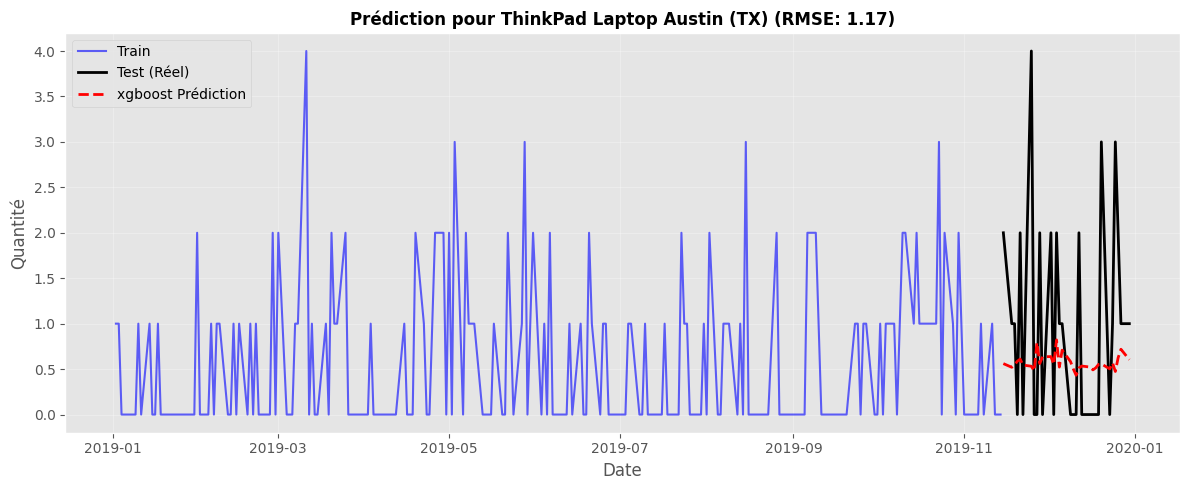


🔹 Analyse: ThinkPad Laptop_Portland (ME)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
=>XGBOOST - RMSE: 0.34, MAE: 0.23


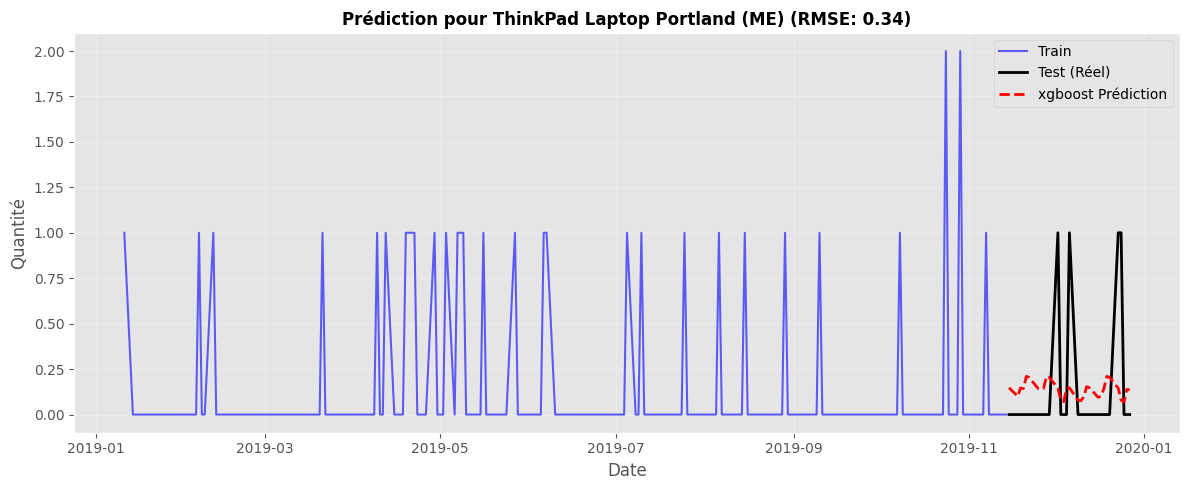


🔹 Analyse: AAA Batteries (4-pack)_San Francisco (CA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
=>XGBOOST - RMSE: 15.25, MAE: 11.20


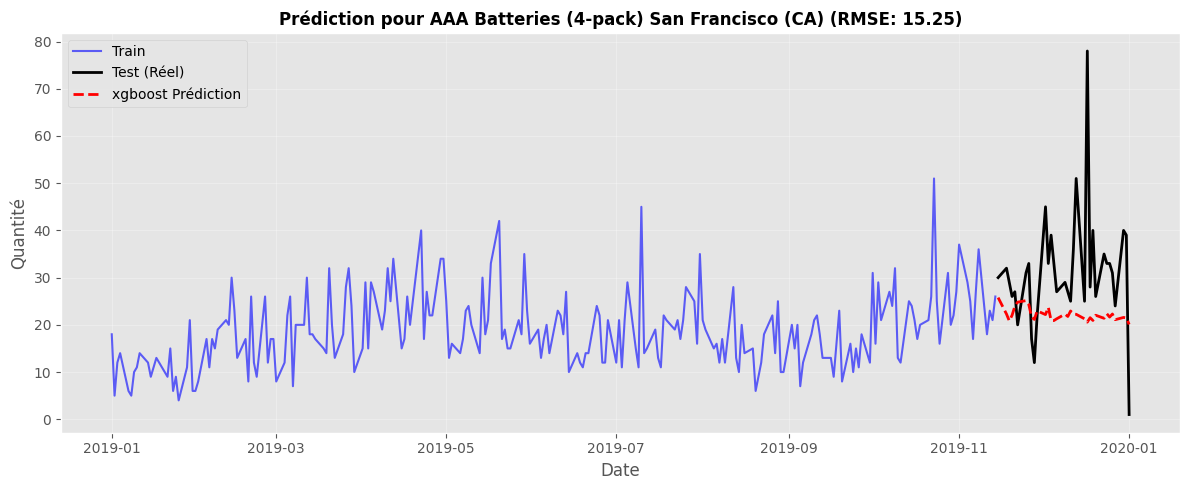


🔹 Analyse: AAA Batteries (4-pack)_Los Angeles (CA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 8.28, MAE: 6.65


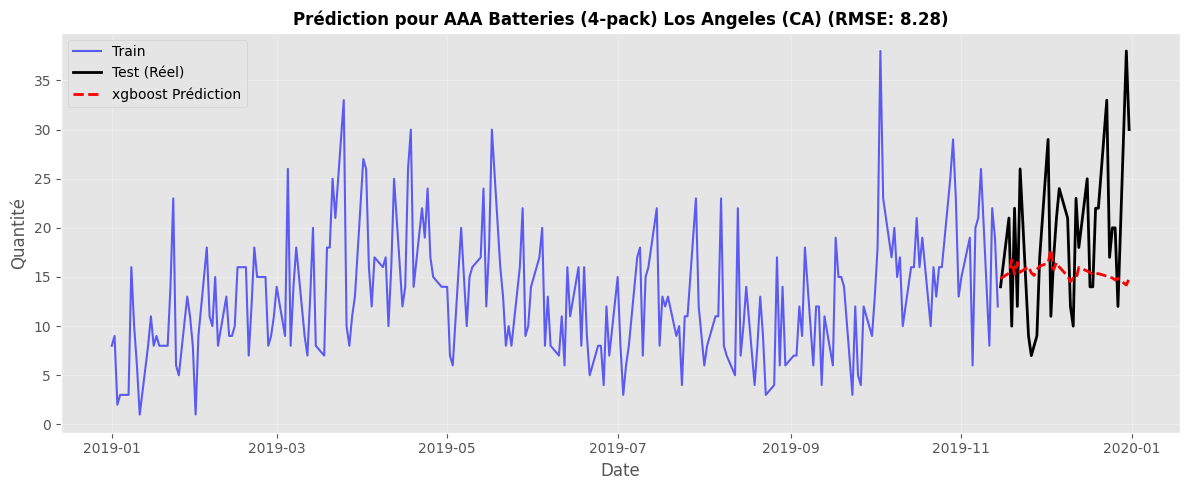


🔹 Analyse: AAA Batteries (4-pack)_New York City (NY)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
=>XGBOOST - RMSE: 6.16, MAE: 5.28


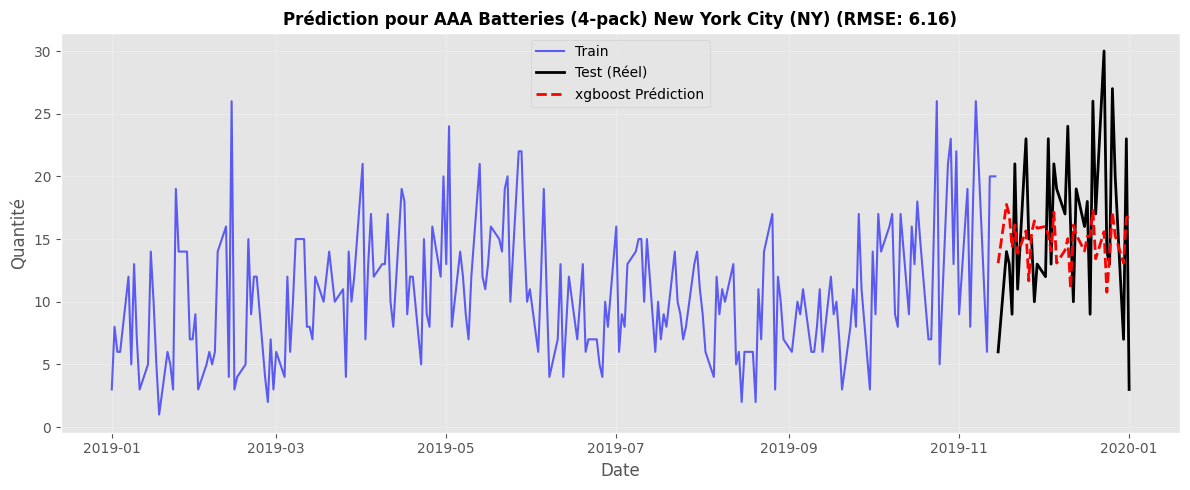


🔹 Analyse: AAA Batteries (4-pack)_Boston (MA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 6.08, MAE: 5.02


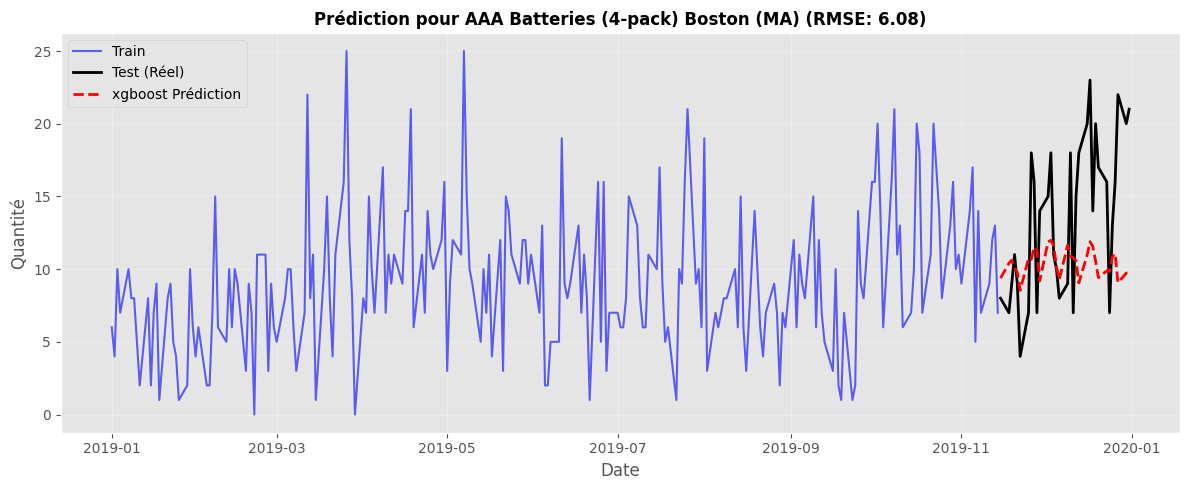


🔹 Analyse: AAA Batteries (4-pack)_Atlanta (GA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 5.37, MAE: 4.06


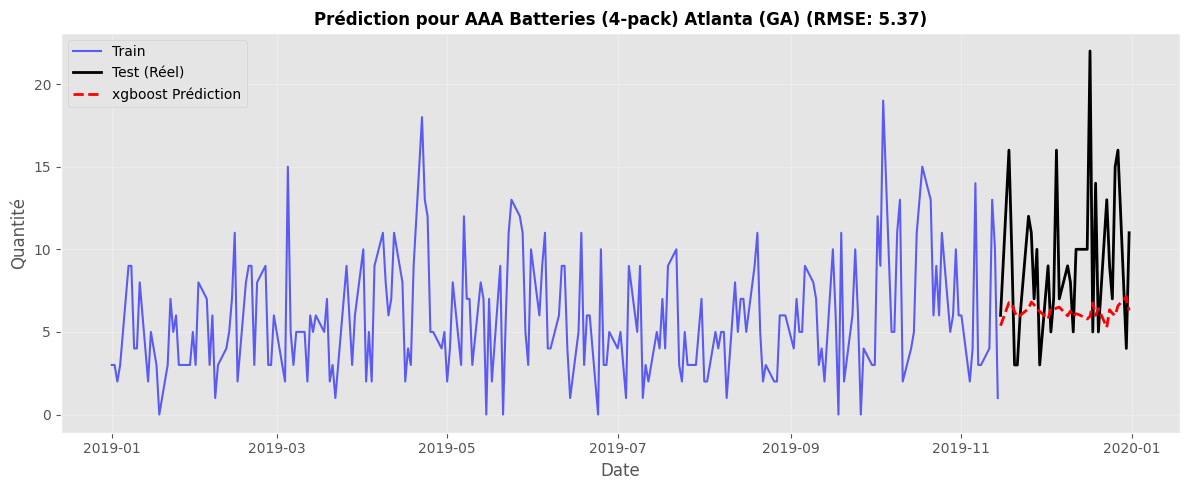


🔹 Analyse: AAA Batteries (4-pack)_Dallas (TX)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
=>XGBOOST - RMSE: 6.40, MAE: 4.78


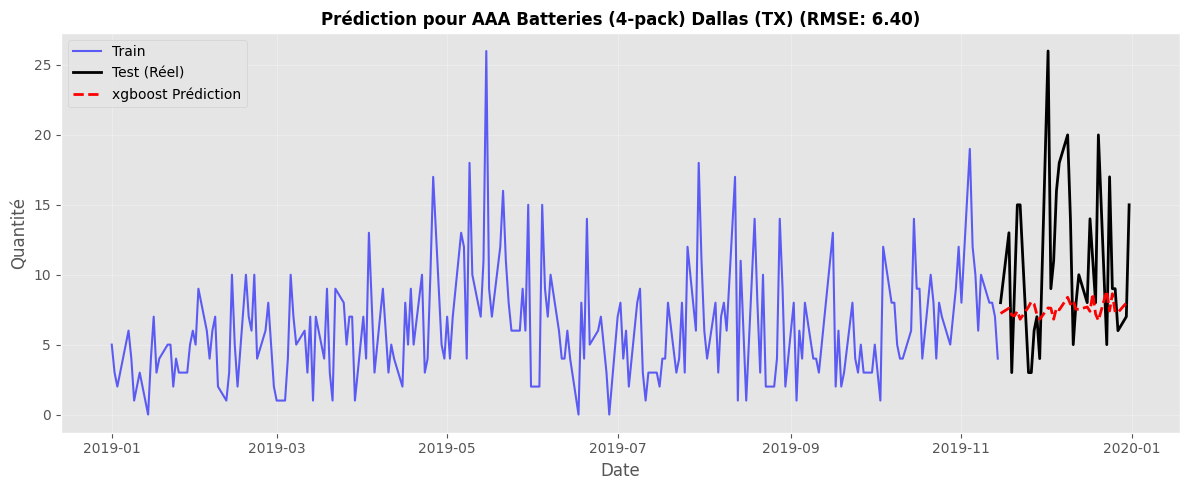


🔹 Analyse: AAA Batteries (4-pack)_Seattle (WA)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 5.22, MAE: 3.83


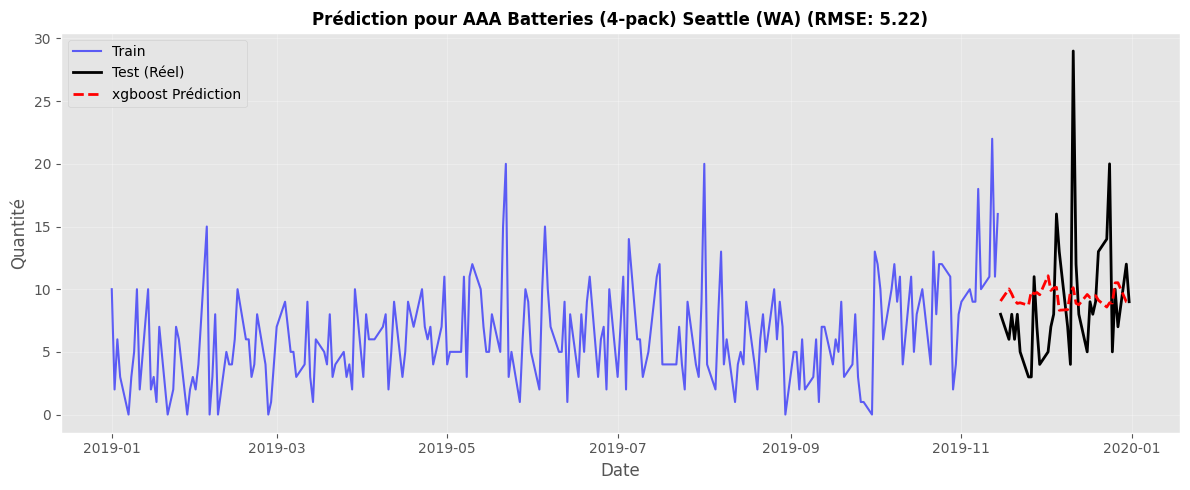


🔹 Analyse: AAA Batteries (4-pack)_Portland (OR)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 4.70, MAE: 3.60


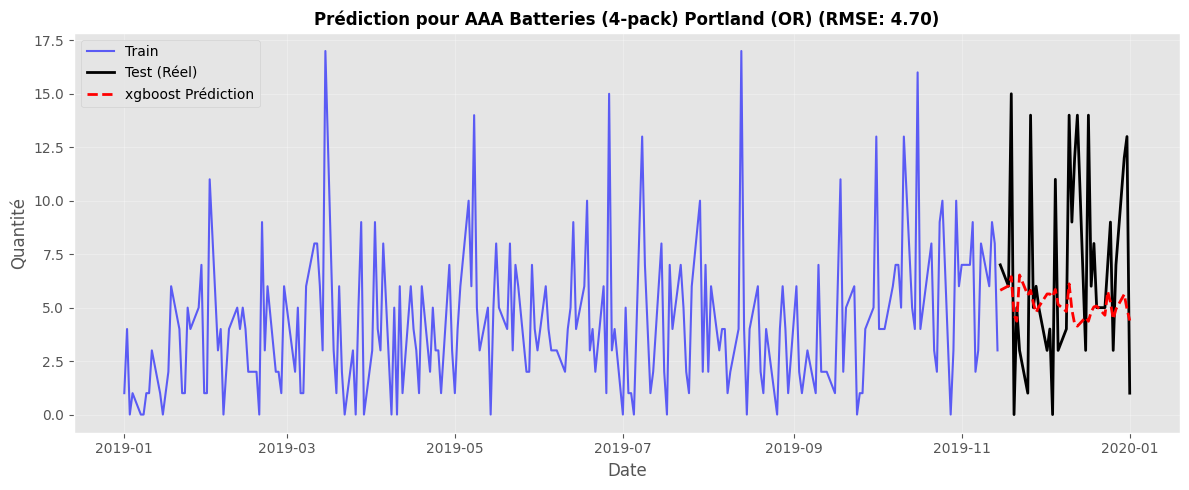


🔹 Analyse: AAA Batteries (4-pack)_Austin (TX)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 4.51, MAE: 3.21


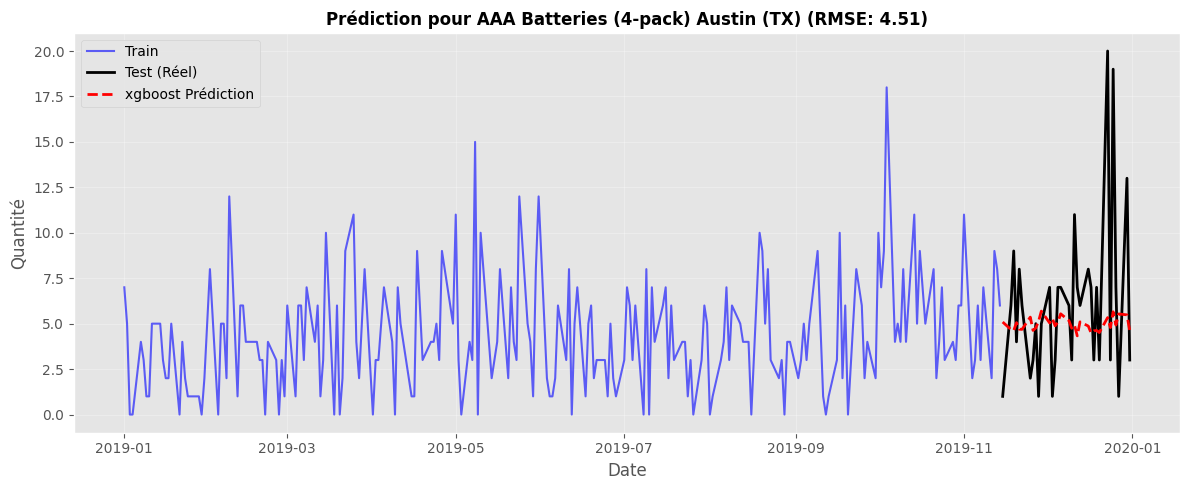


🔹 Analyse: AAA Batteries (4-pack)_Portland (ME)
   ⚡ Optimisation des hyperparamètres XGBoost en cours...
   ✅ Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
=>XGBOOST - RMSE: 2.09, MAE: 1.61


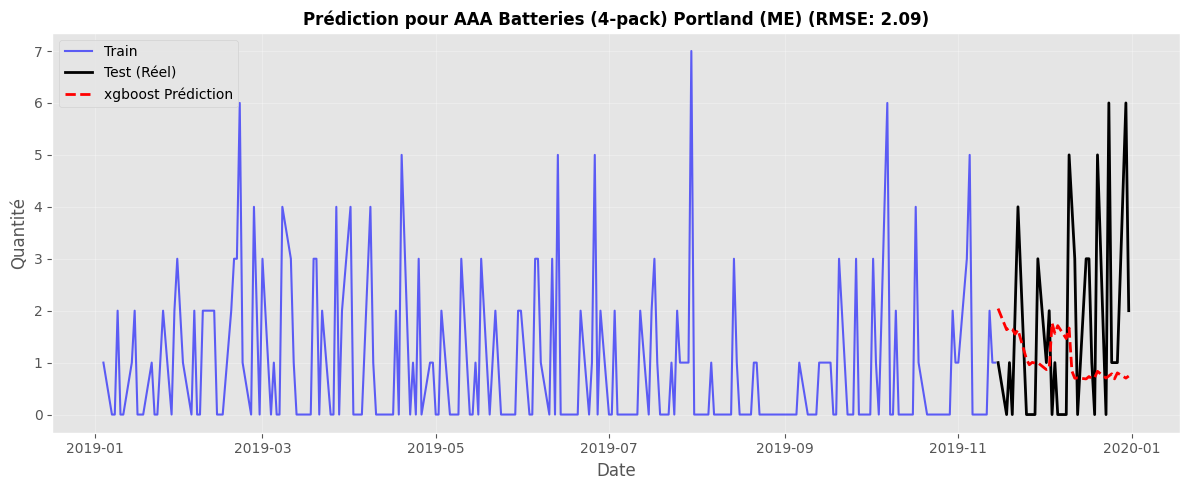

In [58]:
print("="*70)
print("ANALYSE COMPLÈTE AVEC XGBOOST")
print("="*70)
print("ℹ️  XGBoost est utilisé comme modèle principal")
print("="*70)

all_results = analyze_all_series(train_test_splits, model_type='xgboost', use_fallback=True)

## Prédictions futures (60 prochains jours et 3 prochains mois)

Dans cette section, nous utilisons **toutes les données historiques disponibles** pour chaque série temporelle (Produit et City_State), afin de :

- **Prédire les 60 prochains jours ouvrés** de demande.
- **Agréger ces prédictions par mois** pour obtenir la production mensuelle prévue sur les **3 prochains mois**.
- **Construire un CSV comparatif** contenant, pour chaque produit et chaque état (City_State), les quantités prédites par mois.

In [59]:
def forecast_next_60_days_xgb(time_series_data, best_params_dict=None, horizon_days=60):
    all_daily_rows = []
    all_monthly_rows = []

    for key, ts in time_series_data.items():
        print(f"\n🔮 Série: {key}")

        # Utiliser les meilleurs hyperparamètres si disponibles
        if best_params_dict and key in best_params_dict:
            params = best_params_dict[key]
            print(f"Utilisation des hyperparamètres optimaux: {params}")
            try:
                model, feature_cols = train_xgboost(
                    ts,
                    n_estimators=params.get('n_estimators', 100),
                    learning_rate=params.get('learning_rate', 0.01),
                    tune_hyperparameters=False
                )
            except Exception as e:
                print(f"Échec entraînement XGBoost sur {key}: {e}")
                continue
        else:
            # Utiliser les hyperparamètres par défaut (fine-tunés)
            try:
                model, feature_cols = train_xgboost(ts, tune_hyperparameters=False)
            except Exception as e:
                print(f"Échec entraînement XGBoost sur {key}: {e}")
                continue

        try:
            history = ts.copy()
            last_price = history['Average_Price'].iloc[-1]
            last_date = history.index[-1]

            print(f"   📅 Dernière date historique: {last_date.date()}")

            # Index des 60 prochains jours ouvrés APRÈS la dernière date
            future_index = pd.bdate_range(start=last_date + pd.offsets.BDay(1),
                                          periods=horizon_days)

            print(f"=> Prédiction de {future_index[0].date()} à {future_index[-1].date()}")

            preds = []
            temp_hist = history.copy()

            for date in future_index:
                tmp = pd.concat([
                    temp_hist,
                    pd.DataFrame({'Quantity': [0],
                                  'Average_Price': [last_price]}, index=[date])
                ])

                features = create_features(tmp)
                if date not in features.index:
                    print(f"Pas de features valides pour {key} à la date {date.date()}, sauté.")
                    continue

                X = features.loc[[date]][feature_cols]
                y_hat = model.predict(X)[0]
                y_hat = max(y_hat, 0)
                preds.append((date, y_hat))

                # Mettre à jour l'historique avec la valeur prédite pour alimenter les lags
                temp_hist.loc[date, 'Quantity'] = y_hat
                temp_hist.loc[date, 'Average_Price'] = last_price

            if not preds:
                print(f"Aucune prédiction générée pour {key}")
                continue

            daily_df = pd.DataFrame(preds, columns=['Date', 'Predicted_Quantity']).set_index('Date')

            # Décomposition du nom de la série en Produit et City_State
            product, city_state = key.split('_', 1)
            daily_df['Product'] = product
            daily_df['City_State'] = city_state

            all_daily_rows.append(daily_df.reset_index())

            # Agrégation mensuelle (3 premiers mois)
            monthly = daily_df.reset_index().copy()
            monthly['Month'] = monthly['Date'].dt.to_period('M')
            monthly_agg = (
                monthly
                .groupby(['Product', 'City_State', 'Month'])['Predicted_Quantity']
                .sum()
                .reset_index()
            )
            monthly_agg = monthly_agg.sort_values('Month').head(3)
            all_monthly_rows.append(monthly_agg)
        except Exception as e:
            print(f"Erreur de prévision pour {key}: {e}")
            import traceback
            traceback.print_exc()
            continue

    if all_daily_rows:
        daily_forecast_df = pd.concat(all_daily_rows, ignore_index=True)
    else:
        daily_forecast_df = pd.DataFrame()

    if all_monthly_rows:
        monthly_forecast_df = pd.concat(all_monthly_rows, ignore_index=True)
        monthly_forecast_df['Month'] = monthly_forecast_df['Month'].astype(str)
    else:
        monthly_forecast_df = pd.DataFrame()

    return daily_forecast_df, monthly_forecast_df


In [60]:
print("\n" + "="*80)
print("PHASE 1: Recherche des meilleurs hyperparamètres par série")
print("="*80)

best_params_per_series = {}

print("\nUtilisation des hyperparamètres par défaut (fine-tunés) pour toutes les séries")
print("   n_estimators=100, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.9")

print("\n" + "="*80)
print("PHASE 2: Prédictions des 60 prochains jours ouvrés")
print("="*80)

daily_forecast_df, monthly_forecast_df = forecast_next_60_days_xgb(
    time_series_data,
    best_params_dict=best_params_per_series if best_params_per_series else None,
    horizon_days=60
)


PHASE 1: Recherche des meilleurs hyperparamètres par série

Utilisation des hyperparamètres par défaut (fine-tunés) pour toutes les séries
   n_estimators=100, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.9

PHASE 2: Prédictions des 60 prochains jours ouvrés

🔮 Série: ThinkPad Laptop_San Francisco (CA)
   📅 Dernière date historique: 2019-12-31
=> Prédiction de 2020-01-01 à 2020-03-24

🔮 Série: ThinkPad Laptop_Los Angeles (CA)
   📅 Dernière date historique: 2020-01-01
=> Prédiction de 2020-01-02 à 2020-03-25

🔮 Série: ThinkPad Laptop_New York City (NY)
   📅 Dernière date historique: 2019-12-31
=> Prédiction de 2020-01-01 à 2020-03-24

🔮 Série: ThinkPad Laptop_Boston (MA)
   📅 Dernière date historique: 2020-01-01
=> Prédiction de 2020-01-02 à 2020-03-25

🔮 Série: ThinkPad Laptop_Atlanta (GA)
   📅 Dernière date historique: 2019-12-31
=> Prédiction de 2020-01-01 à 2020-03-24

🔮 Série: ThinkPad Laptop_Dallas (TX)
   📅 Dernière date historique: 2019-12-31
=> Prédiction d

In [61]:
daily_forecast_df.head()

Date  Predicted_Quantity          Product          City_State
0 2020-01-01            3.326620  ThinkPad Laptop  San Francisco (CA)
1 2020-01-02            2.777963  ThinkPad Laptop  San Francisco (CA)
2 2020-01-03            3.002128  ThinkPad Laptop  San Francisco (CA)
3 2020-01-06            3.413681  ThinkPad Laptop  San Francisco (CA)
4 2020-01-07            3.306148  ThinkPad Laptop  San Francisco (CA)

In [62]:
monthly_forecast_df.head()

Product          City_State    Month  Predicted_Quantity
0  ThinkPad Laptop  San Francisco (CA)  2020-01           77.045822
1  ThinkPad Laptop  San Francisco (CA)  2020-02           66.355194
2  ThinkPad Laptop  San Francisco (CA)  2020-03           56.412243
3  ThinkPad Laptop    Los Angeles (CA)  2020-01           36.249920
4  ThinkPad Laptop    Los Angeles (CA)  2020-02           33.084969

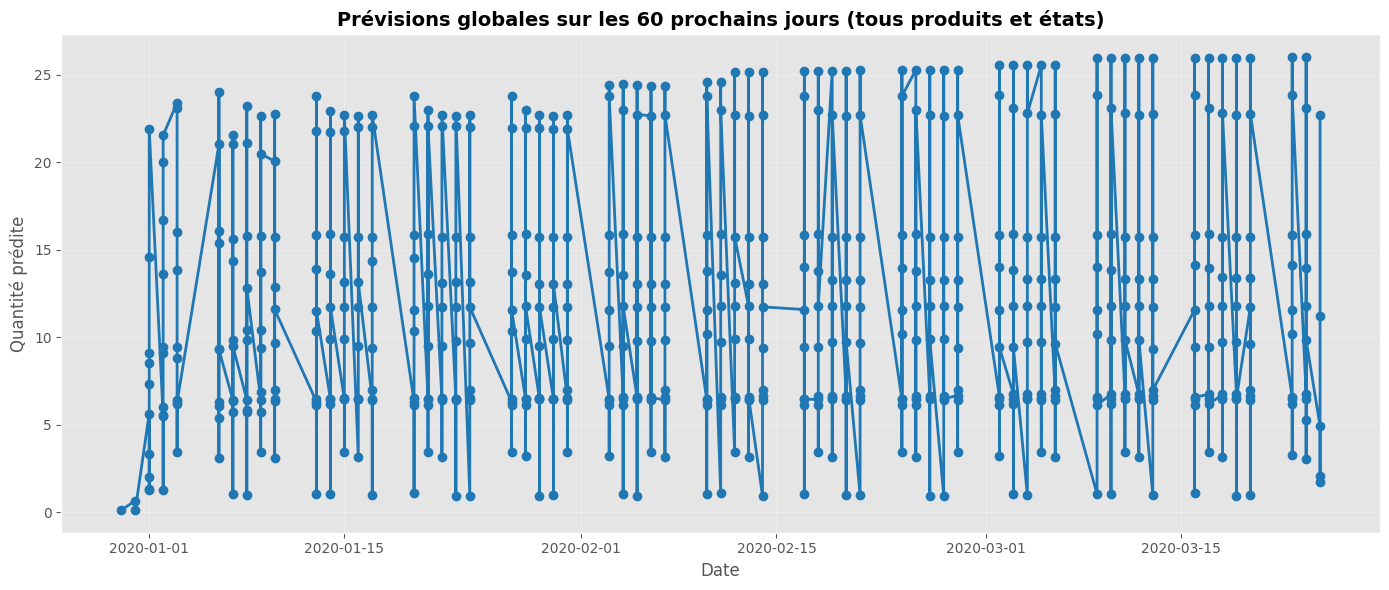

In [63]:
# Visualisation des 60 prochains jours (somme de toutes les séries)
if not daily_forecast_df.empty:
    agg_daily = (
        daily_forecast_df
        .groupby(['Date', 'City_State'], as_index=False)['Predicted_Quantity']
        .sum()
        .sort_values('Date')
    )

    plt.figure(figsize=(14, 6))
    plt.plot(agg_daily['Date'], agg_daily['Predicted_Quantity'], marker='o', linewidth=2, color='tab:blue')
    plt.title("Prévisions globales sur les 60 prochains jours (tous produits et états)", fontsize=14, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Quantité prédite")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Pas de données de prévision journalière pour le plot.")

In [64]:
# Sauvegarde des résultats en CSV
print("\n" + "="*80)
print("💾 PHASE 3: Sauvegarde des prédictions en CSV")
print("="*80)

if not daily_forecast_df.empty:
    # Arrondir les prédictions en entiers
    # daily_forecast_df['Predicted_Quantity'] = daily_forecast_df['Predicted_Quantity'].round().astype(int)

    # Sauvegarder les prédictions journalières
    daily_csv_path = "/content/drive/MyDrive/fluentech/predictions_60_jours.csv"
    daily_forecast_df.to_csv(daily_csv_path, index=False)
    print(f"\n✅ Prédictions journalières (60 jours) sauvegardées: {daily_csv_path}")
    print(f"   {len(daily_forecast_df)} lignes × {len(daily_forecast_df.columns)} colonnes")
    print(f"   📅 Période: {daily_forecast_df['Date'].min()} à {daily_forecast_df['Date'].max()}")
else:
    print("\n⚠️ Aucune prédiction journalière à sauvegarder.")

if not daily_forecast_df.empty:
    # Créer l'agrégation mensuelle par Produit ET City_State
    print("\nAgrégation mensuelle par produit et ville...")

    # Ajouter la colonne Month
    daily_forecast_df['Month'] = pd.to_datetime(daily_forecast_df['Date']).dt.to_period('M')

    # Agréger par Product, City_State et Month
    monthly_forecast_df = (
        daily_forecast_df
        .groupby(['Product', 'City_State', 'Month'])['Predicted_Quantity']
        .sum()
        .reset_index()
    )

    # Arrondir en entiers
    # monthly_forecast_df['Predicted_Quantity'] = monthly_forecast_df['Predicted_Quantity'].round().astype(int)

    # Convertir Month en string pour le CSV
    monthly_forecast_df['Month'] = monthly_forecast_df['Month'].astype(str)

    # Trier par produit, ville et mois
    monthly_forecast_df = monthly_forecast_df.sort_values(['Product', 'City_State', 'Month'])

    # Sauvegarder les prédictions mensuelles
    monthly_csv_path = "/content/drive/MyDrive/fluentech/predictions_3_mois.csv"
    monthly_forecast_df.to_csv(monthly_csv_path, index=False)
    print(f"\n✅ Prédictions mensuelles sauvegardées: {monthly_csv_path}")
    print(f"   {len(monthly_forecast_df)} lignes × {len(monthly_forecast_df.columns)} colonnes")
    print(f"   📋 Colonnes: {', '.join(monthly_forecast_df.columns)}")

    # Afficher un résumé détaillé
    print("\n📈 Résumé des prédictions mensuelles par produit et ville:")
    print("="*80)

    for product in monthly_forecast_df['Product'].unique():
        print(f"\n🔹 {product}:")
        product_data = monthly_forecast_df[monthly_forecast_df['Product'] == product]

        for city_state in product_data['City_State'].unique():
            city_data = product_data[product_data['City_State'] == city_state]
            print(f"\n   📍 {city_state}:")
            for _, row in city_data.iterrows():
                print(f"      {row['Month']}: {row['Predicted_Quantity']:,} unités")

        # Total par produit
        total_product = product_data['Predicted_Quantity'].sum()
        print(f"\n   Total {product}: {total_product:,} unités")

    # Afficher un aperçu du DataFrame
    print("\n" + "="*80)
    print("📋 Aperçu des données mensuelles (premières lignes):")
    print("="*80)
    print(monthly_forecast_df.head(10).to_string(index=False))

else:
    print("\n⚠️ Aucune prédiction mensuelle à sauvegarder.")

print("\n" + "="*80)
print("✅ PROCESSUS TERMINÉ")
print("="*80)




💾 PHASE 3: Sauvegarde des prédictions en CSV

✅ Prédictions journalières (60 jours) sauvegardées: /content/drive/MyDrive/fluentech/predictions_60_jours.csv
   1200 lignes × 4 colonnes
   📅 Période: 2019-12-30 00:00:00 à 2020-03-25 00:00:00

Agrégation mensuelle par produit et ville...

✅ Prédictions mensuelles sauvegardées: /content/drive/MyDrive/fluentech/predictions_3_mois.csv
   62 lignes × 4 colonnes
   📋 Colonnes: Product, City_State, Month, Predicted_Quantity

📈 Résumé des prédictions mensuelles par produit et ville:

🔹 AAA Batteries (4-pack):

   📍 Atlanta (GA):
      2020-01: 214.6447296142578 unités
      2020-02: 199.7308349609375 unités
      2020-03: 169.9503631591797 unités

   📍 Austin (TX):
      2020-01: 121.46588134765625 unités
      2020-02: 106.19637298583984 unités
      2020-03: 90.57018280029297 unités

   📍 Boston (MA):
      2020-01: 315.23565673828125 unités
      2020-02: 272.8447265625 unités
      2020-03: 232.0748748779297 unités

   📍 Dallas (TX):
      

In [65]:
result = pd.read_csv("/content/drive/MyDrive/fluentech/predictions_3_mois.csv")
result.head()

Product    City_State    Month  Predicted_Quantity
0  AAA Batteries (4-pack)  Atlanta (GA)  2020-01           214.64473
1  AAA Batteries (4-pack)  Atlanta (GA)  2020-02           199.73083
2  AAA Batteries (4-pack)  Atlanta (GA)  2020-03           169.95036
3  AAA Batteries (4-pack)   Austin (TX)  2020-01           121.46588
4  AAA Batteries (4-pack)   Austin (TX)  2020-02           106.19637

In [66]:
result.tail()

Product          City_State    Month  Predicted_Quantity
57  ThinkPad Laptop  San Francisco (CA)  2020-02           66.355194
58  ThinkPad Laptop  San Francisco (CA)  2020-03           56.412243
59  ThinkPad Laptop        Seattle (WA)  2020-01           22.528975
60  ThinkPad Laptop        Seattle (WA)  2020-02           21.024162
61  ThinkPad Laptop        Seattle (WA)  2020-03           19.931559

# Présentation